In [1]:
import os
import glob
from pprint import pprint
import json
import pickle
import re
from collections import OrderedDict
from Bio import SeqIO

In [2]:
from rdkit import Chem as chem
from rdkit.Chem import AllChem, Draw
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import imp
helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

In [4]:
file_path = './mibig'
file_names = glob.glob(os.path.join(file_path, '*.json'))

# MiBiG Breakdown

In [5]:
# Erythromycin
test_file = './mibig/BGC0000055.json'
with open(test_file) as json_file:
    test_data = json.load(json_file)
#pprint(test_data.keys())
#pprint(test_data['general_params'].keys())
#pprint(test_data['general_params'])
pprint(test_data['general_params']['loci']['nucl_acc'][0]['Accession'])
pprint(test_data['general_params']['Polyketide'])
#pprint([compound['compound'] for compound in test_data['general_params']['compounds']])

'AM420293'
{'lin_cycl_pk': 'Cyclic',
 'mod_pks_genes': [{'mod_pks_gene': 'CAM00062.1',
                    'pks_module': [{'at_substr_spec': 'Propionyl-CoA',
                                    'evidence_at_spec': 'Structure-based '
                                                        'inference',
                                    'module_nr': '0',
                                    'pks_domains': ['AT', 'T'],
                                    'pks_mod_doms': ['None'],
                                    'pks_mod_skip_iter': 'Neither'},
                                   {'at_substr_spec': 'Methylmalonyl-CoA',
                                    'evidence_at_spec': 'Structure-based '
                                                        'inference',
                                    'kr_stereochem': 'D-OH',
                                    'module_nr': '1',
                                    'pks_domains': ['KS', 'AT', 'KR', 'T'],
                                    'pk

In [6]:
# See what kind of PKS subtype labels there are
labels = []
for file_name in file_names:
    with open(file_name) as json_file:
        json_data = json.load(json_file)
    try:
        labels.extend(json_data['general_params']['Polyketide']['pks_subclass'])
    except KeyError:
        pass
print(set(labels))

{'Type I', 'Enediyne type I', 'Type II', 'Type III', 'Modular type I', 'Iterative type I', 'Modular Type I', 'Trans-AT type I', 'PUFA synthase or related', 'Other', 'Iterative typeI'}


In [7]:
# This gets all the modular type I PKSs contained in MiBiG (at least the examples that are so labeled)
t1pks = []
for file_name in file_names:
    with open(file_name) as json_file:
        json_data = json.load(json_file)
    try:        
        if len(set(['Modular type I', 'Modular Type I', 'Type I']).intersection(set(json_data['general_params']['Polyketide']['pks_subclass']))) > 0:
            accession = json_data['general_params']['loci']['nucl_acc'][0]['Accession']
            t1pks.append((file_name.split('/')[-1].split('.')[0], accession))
    except KeyError:
        pass
#print(len(t1pks))
#print([entry[1] for entry in t1pks])
# with open('./mibig/antismash/t1pks_list.txt', 'w') as f:
#     for entry in t1pks:
#         f.write(entry[0].split('/')[-1].split('.')[0] + '\n')

In [8]:
# Number of clusters found
print('%d potential type I modular PKS clusters found!' %(len(t1pks)))
# Iterate over list of type I modular PKSs
for i in range(len(t1pks)):
    entry = t1pks[i]
    # This prints the product compounds for the clusters
    with open(os.path.join(file_path, entry[0] + '.json')) as json_file:
        mibig_data = json.load(json_file)
        pprint([compound['compound'] for compound in mibig_data['general_params']['compounds']])

352 potential type I modular PKS clusters found!
['Abyssomicin C', 'Atrop-abyssomicin C']
['aculeximycin']
['AF-toxin']
['aflatoxin']
['aflatoxin']
['aflatoxin']
['aflatoxin']
['aflatoxin']
['aflatoxin']
['aflatoxin']
['aflatoxin', 'sterigmatocystin']
['alternapyrone']
['alternariol']
['ambruticin']
['amphotericin']
['Anatoxin-a', 'Homoanatoxin-a']
['angolamycin']
['angolamycin']
['ansamitocin']
['apoptolidin']
['asperfuranone']
['Aurafuron A']
['aureothin']
['avermectin']
['Bafilomycin B1']
['BE-14106']
['bikaverin']
['Borrelidin']
['calcimycin']
['calicheamicin']
['candicidin']
['chalcomycin']
['chlorothricin', 'deschlorothricin']
['cichorine']
['coelimycin P1']
['compactin']
['concanamycin A']
['coronafacic acid']
['cremimycin']
['curacin A']
['dehydrocurvularin']
['dihydrochalcomycin']
['dothistromin']
['E-492', 'E-975']
['E-837']
['ebelactone']
['ECO-02301']
['elaiophylin']
['erythromycin']
['Erythromycin A', 'Erythromycin B', 'Erythromycin C', 'Erythromycin D']
['esperamicin']
['

In [9]:
# Get keys for genes
keys = []
for i in range(len(t1pks)):
    entry = t1pks[i]
    # This prints the product compounds for the clusters
    with open(os.path.join(file_path, entry[0] + '.json')) as json_file:
        mibig_data = json.load(json_file)
        # Iterate over all subunits getting domains
        keys.extend(list(mibig_data['general_params']['Polyketide'].keys()))
print(set(keys))

{'starter_unit', 'pks_genes', 'trans_at', 'pk_subclass', 'pks_te_type', 'mod_pks_genes', 'pks_subclass', 'pks_thioesterase', 'Saccharide', 'nr_iterations', 'cyclases', 'lin_cycl_pk', 'pks_release_type', 'iter_cycl_type', 'iterative_subtype', 'ketide_length'}


In [10]:
# Get set of catalytic domains found across all type I modular PKSs
domains = []
lin_cyc = []
for i in range(len(t1pks)):
    entry = t1pks[i]
    # This prints the product compounds for the clusters
    with open(os.path.join(file_path, entry[0] + '.json')) as json_file:
        mibig_data = json.load(json_file)
        # Iterate over all subunits getting domains
        try:
            pks_genes = mibig_data['general_params']['Polyketide']['mod_pks_genes']
            lin_cyc.append(mibig_data['general_params']['Polyketide']['lin_cycl_pk'])
        except KeyError:
            continue
        for subunit in pks_genes:
            subunit_name = re.sub(r'\s+', '', subunit['mod_pks_gene'])
            subunit_modules = subunit['pks_module']
            for module in subunit_modules:
                domains.extend(module['pks_domains'])
print(set(domains))
print(set(lin_cyc))

{'ACP', 'AT', 'KR', 'C', 'Acyltransferase', 'Ketosynthase', 'Enoylreductase', 'CoA-ligase', 'Dehydratase', 'Ketoreductase', 'TE', 'CAL', 'Thiolation (ACP/PCP)', 'ST', 'T', 'KS', 'ER', 'FAAL', 'A', 'DH'}
{'Cyclic', 'Linear'}


In [11]:
# antiSMASH output from Tyler
antismash_file_path = './mibig/antismash/split_files'

# Proccessing functions

In [12]:
def process_subunit_modules(sec_met): 
    '''This function takes as input the the list recorded by feature.qualifiers['sec_met'] for a module in a PKS
       cluster. This assumes that feature.type=='CDS' and that feature.qualifiers has the key 'sec_met'.
       The function returns a dict corresponding to the modules in the subunit, indexed starting from zero within
       the subunit. If the first entry of 'sec_met' is not 'Type: t1pks' then nothing is returned.
    '''
    # Initialize dict for the subunit
    # keys: module number
    # values: OrderedDict of domains in module
    #         within OrderedDict, key is domain name and value is a length 2 list where the
    #         first element is a dictionary {start:, stop:} and the second element is specificity dictionary 
    subunit = {}
    
    # This is for the current module (function processes subunit which may have more than one module)
    module_index = 0  # key for module
    module_domains = [] # list of domains in module
    old_module_domains = [] # pre-initialize in case subunit starts with a domain
                            # that is expected to end the module
    
    # This is how domains appear in sec_met:
    # ['PKS_AT', 'PKS_KS', 'PKS_KR', 'PKS_DH', 'PKS_ER', 'ACP', 'Thioesterase']
    # Iterate over the entries in sec_met, and add them to the module_domains list 
    for entry in sec_met:    
        # Split entry into a list
        entrysplit = [item.strip() for item in entry.split(';') if item != '']
        # Split part of entry that is expected to describe catalytic domain
        domainsplit = entrysplit[0].split()
        # This is just different ways of processing the name of the domain depending
        # on how the name of the domain is formatted
        if ' '.join(domainsplit[:2]) == 'NRPS/PKS Domain:' and len(domainsplit) > 2:
            # Note that we want to make sure that there is a leading 'PKS_' before we do our trimming
            if domainsplit[2].split('_')[0] == 'PKS':
                if domainsplit[2] in ['PKS_Docking_Nterm', 'PKS_Docking_Cterm']:
                    domaintype = domainsplit[2]
                else:
                    # We trim off the leading 'PKS_'
                    # Assume 'DH2' and 'DHt' are the same as 'DH' 
                    domaintype = domainsplit[2].split('_')[-1].replace('DHt', 'DH').replace('DH2', 'DH')
            # Special case of 'CAL' domain
            elif domainsplit[2] == 'CAL_domain':
                domaintype = 'CAL'
            else:
                domaintype = domainsplit[2]
        else:
            continue
    
        # DEBUG
#        print(domaintype)
    
        # These are the catlytic domains that we want to recognize
        if domaintype not in ['KS', 'AT', 'KR', 'DH', 'ER', 'ACP', 'Thioesterase', 
                              'cMT', 'oMT', 'CAL', 'PCP', 
                              'Heterocyclization', 'AMP-binding', 
                              'Condensation_DCL', 'Condensation_LCL',
                              'PKS_Docking_Nterm', 'PKS_Docking_Cterm']:
            # Break out of for loop and stop looking for additional catalytic domains if 
            # we encountered a domain that we don't recognize
            # we end up excluding any subunit that has a non-recognized catalytic domain
            # this is dealt with by checking subunits against those that are expected to be recognized
            # as determined by the MiBiG JSON file
            break    
        # Get the obundaries of the catalytic domain
        boundaries = [int(bound) for bound in domainsplit[3].replace('(', '').replace(')', '').replace('.', '').split('-')]
        
        # Here, we add each domain to a list, which will be converted to an OrderedDict
        # based on whether or not the domain is expected to have substrate specificity annotations
        if domaintype in ['KS', 'DH', 'ER', 'ACP', 'cMT', 'oMT', 'CAL', 'PCP',
                          'Heterocylization', 'AMP-binding', 
                          'Condensation_DCL', 'Condensation_LCL',
                          'PKS_Docking_Nterm', 'PKS_Docking_Cterm']:   # Recall that we trimmed leading 'PKS_'
            module_domains.append((domaintype, [{'start': boundaries[0], 'stop': boundaries[1]}]))
        # Include substrate and stereospecificity annotations for AT and KR domains respectively
        if domaintype in ['AT', 'KR']:   # Recall that we trimmed leading 'PKS_'
            notesdict = {}
            for note in entrysplit[1:]:
                item = note.split(': ')
                notesdict[item[0]] = item[1]
            module_domains.append((domaintype, [{'start': boundaries[0], 'stop': boundaries[1]}, notesdict]))
                
        # End of the module has been reached of the domain is 'ACP' or 'PCP
        if domaintype in ['ACP', 'PCP']:
            domains_present = [d[0] for d in module_domains]
            # Make sure every module has an AT, or else it isn't a valid module and we just ignore it
            # This means it will be excluded from the subunit, which makes sense since we can't 
            # really perform a polyketide chain extension without an AT
            if 'AT' in domains_present:            
                subunit[module_index] = OrderedDict(module_domains)
                old_module_domains = module_domains
                module_index += 1
            else:
                old_module_domains = []
            module_domains = []
        # These domains may come after the ACP or PCP, so if they are encountered, we add
        # them to previous module and keep going forward
        if domaintype in ['Thioesterase', 'PKS_Docking_Cterm', 'Condensation_LCL']:
            # Overwrite previous subunit, or else will have duplicate entries
            old_module_domains.append((domaintype, [{'start': boundaries[0], 'stop': boundaries[1]}]))
            subunit[module_index - 1] = OrderedDict(old_module_domains)
            module_domains = []
            
    return subunit

In [13]:
def get_gene_data(record):
    '''Takes as input a record read in from an MiBiG GenBank file using SeqIO.read() and outputs PKS data 
       from that record. Data will be comprised of PKS subunits and standalone PKS genes.
    '''
    # Get list to hold information about all genes that are in the record
    gene_data = []
    
    # Only the "CDS" features are potentially genes
    # Here we get genes that aren't necessarily subunits
    for feature in record.features:
        # These are the features we are interested in
        if feature.type == 'CDS' and 'protein_id' in feature.qualifiers.keys() and 'gene' in feature.qualifiers.keys(): 
            # This gets the location of the feature
            location = feature.location
            # Potential information about gene
            if 'product' in feature.qualifiers.keys():
                description = feature.qualifiers['product'][0]
            gene_data.append([feature.qualifiers['protein_id'][0],
                              feature.qualifiers['gene'][0],
                             ])
            # Feature may not be a PKS module and therefore may not have have subunits 
            # (this will be overwritten if it does have subunits)
            subunit_modules = None
            # Information if gene is PKS subunit
            if 'sec_met' in feature.qualifiers.keys() and len(feature.qualifiers['sec_met']) > 3:
                if feature.qualifiers['sec_met'][3] in ['NRPS/PKS subtype: Type I Modular PKS', 
                                                        'NRPS/PKS subtype: PKS-like protein',
                                                        'NRPS/PKS subtype: PKS/NRPS-like protein',
                                                        'NRPS/PKS subtype: Hybrid PKS-NRPS']:                    
                    # DEBUG
#                    print(feature.qualifiers['gene'][0])
                    # This gets the subunit information                    
                    subunit_modules = process_subunit_modules(feature.qualifiers['sec_met'])
#                else:
#                    print(feature)
            
            # More general information
            gene_data[-1].extend([description, [location.start.position, location.end.position]])

            # Subunit information (if it doesn't have subunit information, assumed to be a standalone enzyme)
            if subunit_modules:
                gene_data[-1].append(subunit_modules)

            # General information about gene
            gene_data[-1].append(feature.qualifiers['translation'][0])

    return gene_data

In [14]:
def check_json_module_validity(module_list):
    '''Function that makes sure module specified in JSON file is valid,
       that is to say, make sure that it contains KS, AT, and ACP or PCP.
       AT least as of February 24, 2017, the names of these domains appear
       only in the following forms in clusters that are annotated as Type I modular PKSs
       ['KS', 'AT', 'T']
       ['Ketosynthase', 'Acyltransferase', 'Thiolation (ACP/PCP)']
    '''
    at_check = len(set(['AT', 'Acyltransferase']).intersection(set(module_list)))
    acp_check = len(set(['ACP', 'PCP', 'T', 'Thiolation (ACP/PCP)']).intersection(set(module_list)))

    if at_check and acp_check:
        return True
    else:
        return False

def process_cluster(record, mibig_json):
    '''Takes in a record and corresponding MiBiG json file
       then returns pks.Cluster object representing the cluster.
    '''
    # Get information about the gene
    gene_data = get_gene_data(record)
    if len(gene_data) == 0:
        return

    # Initalize lists for subunits and standalones
    # We make two dictionaries because sometimes the subunit name in the MiBiG JSON files
    # is the gene name, e.g. eryA1, and sometimes it is the accession number, e.g. A0000000
    unordered_subunits = {}
    unordered_subunits_alt = {}
    standalones = []
     
    # Recall that each entry in gene_data is a list
    # [protein id, gene, product, [location start, location end], subunit dict (optional), translation]
    
    #####################
    # Basic information #
    #####################
    
    counter = 1
    for gene in gene_data:
        geneid = gene[0].strip()
        genename = gene[1].strip()
        genedesc = gene[2].strip()
        genestart = gene[3][0]
        genestop = gene[3][1]
        genetranslation = gene[-1].strip()

        # Just use length of gene_data to differentiate between standalones and subunits
        if len(gene) == 6:
            # We do this to take care of duplicated gene names, as is the case wity tylactone (BGC0000166)
            if genename in unordered_subunits_alt.keys():
                genename = genename + '_' + str(counter)
                counter += 1
 
            # Get subunit data from gene
            genesubunitdata = gene[-2]
            # Here we use the two dictionary options to save the unordered subunits
            # Sometimes MiBiG uses geneid and sometimes it uses genename to reference subunits
            unordered_subunits[geneid] = (genename, genedesc, genestart, genestop,
                                            genesubunitdata, genetranslation)
            unordered_subunits_alt[genename] = (geneid, genedesc, genestart, genestop,
                                                genesubunitdata, genetranslation)
        else:
            # Standalones lack subunit and orphan entries
            assert len(gene) == 5, gene
            standalones.append(pks.Standalone(geneid, genename, genedesc, 
                                              genestart, genestop, genetranslation))
        
    #########################################
    # JSON file has cyclization information #
    #########################################

    # Get ordered version of subunits from corresponding JSON file
    with open(mibig_json) as json_file:
        mibig_data = json.load(json_file)
    
    # Get PKS cyclization information
    # this will be either 'Cyclic' or 'Linear'
    try:
        lin_cycl_pk = mibig_data['general_params']['Polyketide']['lin_cycl_pk']
        if lin_cycl_pk == 'Cyclic':
            cyclize = 'Cyclic'
        elif lin_cycl_pk == 'Linear':
            cyclize = 'Linear'
        else:
            raise Exception("lin_cycl_pk expected to be 'Cyclic' or 'Linear'.")
    except KeyError:
        cyclize = 'Linear'
            
    #####################################
    # JSON file has subunit information #
    #####################################
        
    # Note that all gene data has now been processed, want to reprocess to get right ordering 
    # We strip out subunits that have invalid modules
    try:
        ordered_subunits = []
        for subunit in mibig_data['general_params']['Polyketide']['mod_pks_genes']:
            subunit_name = re.sub(r'\s+', '', subunit['mod_pks_gene'])
            subunit_modules = subunit['pks_module']

            valid_subunit = True
            # This checks if the module is valid
            for module in subunit_modules:
                # Just for debugging
    #            print(module['pks_domains'])
                if not check_json_module_validity(module['pks_domains']):
                    valid_subunit = False
            if valid_subunit:
                ordered_subunits.extend(subunit_name.split(','))
            else:
                # Loop is broken once first invalid subunit is encountered
                break
        # If no valid subunits, then just return
        if len(ordered_subunits) == 0:
            print('\tNo valid subunits!')
            for subunit in mibig_data['general_params']['Polyketide']['mod_pks_genes']:
                subunit_name = re.sub(r'\s+', '', subunit['mod_pks_gene'])
                subunit_modules = subunit['pks_module']
                for module in subunit_modules:
                    print(module['pks_domains'])
            return
        # This makes sure the subunit accession naming is consistent
        # The purpose of these two 'if' statements is because there may be cases in the MiBiG JSON file
        # where the name of the gene is for example, 'eryA1, A000000' and we want to keep consistant naming
        if len(ordered_subunits[0]) >= 8:
            ordered_subunits = [entry for entry in ordered_subunits if len(entry) >= 8]
        if len(ordered_subunits) > 1:
            if len(ordered_subunits[1]) >= 8:
                ordered_subunits = [entry for entry in ordered_subunits if len(entry) >= 8]
        # This is because sometimes the accession number under which the gene is recorded sometimes
        # has a version number, and sometimes does not
        if len(ordered_subunits[0].split('.')) == 1 and len(ordered_subunits[0]) == 8:
            ordered_subunits = [entry + '.1' for entry in ordered_subunits]

        # Check if subunit is in either dictionary
        for isubunit,subunit in enumerate(ordered_subunits):
            if subunit not in set(list(unordered_subunits.keys()) + list(unordered_subunits_alt.keys())):
                print('Missing subunit: "%s"' %(subunit))
                for gene in mibig_data['general_params']['Polyketide']['mod_pks_genes']:
                    if gene['mod_pks_gene'] == subunit:
                        module = gene['pks_module']
                        for entry in module:
                            print(entry['pks_domains'])
                print(unordered_subunits.keys())
                return
    #    print([gene_ref for gene_ref in mibig_data['general_params']['Polyketide']['mod_pks_genes']])

        # Determine whether to use standard or alternative dict
        if len(ordered_subunits[0]) >= 8:
            alt = False
        else:
            alt = True
    
    # Just use unordered gene order if the gene ordering is not already in the JSON file 
    except Exception:
        ordered_subunits = list(unordered_subunits_alt.keys())
        ordered_subunits.sort()
        alt = True

    ####################################
    # This does the subunit reordering #
    ####################################
    # Initialize final list of subunits
    subunits = []
    
    modules_seen = 0
    for subunit in ordered_subunits:
        # subunit data has form (id, description, start, stop, module dict, sequence)
        if not alt:
            subunitdata = unordered_subunits[subunit]
        else:
            subunitdata = unordered_subunits_alt[subunit]
        # Initialize list to hold processed modules
        # this is a list of module objects that we will pass to pks.Subunit()
        modules = []
        # This is the modules for the subunit
        moduledata = subunitdata[-2]
        
        # We do this so we can lump in the loading didomain and TE on the first and last modules respectively
        modulekeys = list(moduledata.keys())
        imodule = 0
        while imodule < len(modulekeys):
            # Get info
            keys = list(moduledata[modulekeys[imodule]].keys())
            values = moduledata[modulekeys[imodule]].values()
            # Process info according to loading or not
            if modules_seen == 0:
                loading = True                
                # Don't name KSQ and ATL separate after all
#                moduledict =  OrderedDict([(k.replace('KS', 'KS').replace('AT', 'AT'), v) \
#                                          if k in ['KS','AT'] \
#                                          else (k,v) \
#                                          for k,v in zip(keys,values)])
                moduledict =  OrderedDict([(k,v) for k,v in zip(keys,values)])
            else: 
                loading = False
                moduledict = OrderedDict([(k,v) for k,v in zip(keys,values)])
            # Determine whether module is terminal or not
            if 'Thioesterase' in list(moduledata[modulekeys[imodule]].keys()):
                terminal = cyclize
            else:
                terminal = None
            imodule += 1
            modules_seen += 1
            try:
                # This is to make sure we don't add subunits with invalid modules
                # The check for errors here is to compare agains the predicted chemcial structure
                domains_present = moduledict.keys()
                if 'ACP' in domains_present or 'PCP' in domains_present:
                    if 'AT' in domains_present or 'ATL' in domains_present:
                        modules.append(pks.Module(moduledict, loading=loading, terminal=terminal))
            except AssertionError as e:
                print(moduledict)
                print(type(e).__name__, e.args, subunit + ' ' + subunitdata[1])
                raise Exception(type(e).__name__, e.args, subunit + ' ' + subunitdata[1])
                break
        # Add subunit to list
        if len(modules) > 0:
            if not alt:
                subunits.append(pks.Subunit(subunit, subunitdata[0], subunitdata[1],
                                            subunitdata[2], subunitdata[3], subunitdata[-1],
                                            modules))
            else:
                subunits.append(pks.Subunit(subunitdata[0], subunit, subunitdata[1],
                                            subunitdata[2], subunitdata[3], subunitdata[-1],
                                            modules))
        else:
            return

        # We take the last Subunit object and change the TE contained in the subunit to cyclize if necessary
        if cyclize:
            final_module = subunits[-1].modules[-1]
            if final_module.terminal == True:
                assert 'Thioesterase' in list(final_module.domains.keys()), \
                    "Terminal module lacks 'Thioesterase' in domains dictionary."
                TE = final_module.operations[-1]
                TE.cyclize = True
        
    return (subunits, standalones)

In [15]:
# Testing specific entries
entry = ('BGC0000166', 'U78289')  # tylactone
#entry = ('BGC0000033', 'AF497482') # calicheamicin

with open(os.path.join(file_path, entry[0] + '.json')) as json_file:
    mibig_data = json.load(json_file)
#pprint(test_data.keys())
#pprint(test_data['general_params'].keys())
#pprint(test_data['general_params'])
#pprint([gene_ref['mod_pks_gene'] for gene_ref in test_data['general_params']['Polyketide']['mod_pks_genes']])
record = SeqIO.read(os.path.join(antismash_file_path, entry[0] + '.embl'), "embl")

# antismash_data = get_gene_data(record)
# for subunit in antismash_data:
#     if len(subunit) == 6:
#         print(subunit)

subunits, standalones = process_cluster(record, os.path.join(file_path, entry[0] + '.json'))
print(subunits)

[<pks.Subunit object at 0x7f26f56e9f60>, <pks.Subunit object at 0x7f26f56ee400>, <pks.Subunit object at 0x7f26f56eeda0>, <pks.Subunit object at 0x7f26f56f4128>, <pks.Subunit object at 0x7f26f56f4588>]


# Process all clusters

In [16]:
import imp
helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

In [17]:
entry = ('BGC0000166', 'U78289')
record = SeqIO.read(os.path.join(antismash_file_path, entry[0] + '.embl'), "embl") 
#print(record.__dict__)
print(record.annotations['comment'].split()[-1].strip().strip('.'))

U78289.1


In [18]:
# Initialize dictionary to hold clusters and counter for valid clusters
cluster_dict = {}
valid = 0

# Iterate over list of type I modular PKSs
for i in range(len(t1pks)):
    print('%d: %s' %(i, t1pks[i]))
    entry = t1pks[i]

     # This prints the accession number and product compound of the cluster
    with open(os.path.join(file_path, entry[0] + '.json')) as json_file:
        mibig_data = json.load(json_file)
        pprint([compound['compound'] for compound in mibig_data['general_params']['compounds']])

    # Read in cluster data
    record = SeqIO.read(os.path.join(antismash_file_path, entry[0] + '.embl'), "embl")    

    # Basic information
    cluster_id = record.id
    cluster_name = record.annotations['comment'].split()[-1].strip().strip('.')
    cluster_description = record.description
    cluster_sequence = record.seq
    
    # Subunit information
    try:
        subunits, standalones = process_cluster(record, os.path.join(file_path, entry[0] + '.json'))
        cluster = pks.Cluster(cluster_id, cluster_name, cluster_description, cluster_sequence,
                              subunits, standalones)
        cluster_dict[cluster_id] = cluster
        valid += 1
    # If we can't process the cluster, then we show the exception
    # We just use this for troubleshooting
    except Exception as e:
        print(Exception(type(e).__name__, e.args))

# Print number of valid clusters
print(valid)

0: ('BGC0000001', 'JF752342')
['Abyssomicin C', 'Atrop-abyssomicin C']
1: ('BGC0000002', 'CP007155')
['aculeximycin']
2: ('BGC0000003', 'AB179766')
['AF-toxin']
3: ('BGC0000004', 'AB196490')
['aflatoxin']
4: ('BGC0000005', 'AF452809')
['aflatoxin']
5: ('BGC0000006', 'AY510451')
['aflatoxin']
6: ('BGC0000007', 'AY510452')
['aflatoxin']
('TypeError', ("'NoneType' object is not iterable",))
7: ('BGC0000008', 'AY510453')
['aflatoxin']
('TypeError', ("'NoneType' object is not iterable",))
8: ('BGC0000009', 'AY510454')
['aflatoxin']
('TypeError', ("'NoneType' object is not iterable",))
9: ('BGC0000010', 'AY510455')
['aflatoxin']
('TypeError', ("'NoneType' object is not iterable",))
10: ('BGC0000011', 'AY092402')
['aflatoxin', 'sterigmatocystin']
('TypeError', ("'NoneType' object is not iterable",))
11: ('BGC0000012', 'AB120221')
['alternapyrone']
12: ('BGC0000013', 'BN001304')
['alternariol']
('TypeError', ("'NoneType' object is not iterable",))
13: ('BGC0000014', 'DQ897667')
['ambruticin']


/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 113193, found 135074 (BGC0000015.1).
  BiopythonParserWarning)


20: ('BGC0000022', 'AACD01000015')
['asperfuranone']
('TypeError', ("'NoneType' object is not iterable",))
21: ('BGC0000023', 'AM850130')
['Aurafuron A']
22: ('BGC0000024', 'AJ575648')
['aureothin']
23: ('BGC0000025', 'AB032523')
['avermectin']
24: ('BGC0000028', 'GU390405.1')
['Bafilomycin B1']
('TypeError', ("'NoneType' object is not iterable",))
25: ('BGC0000029', 'FJ872523')
['BE-14106']
26: ('BGC0000030', 'HF679027')
['bikaverin']
('TypeError', ("'NoneType' object is not iterable",))
27: ('BGC0000031', 'AJ580915')
['Borrelidin']
28: ('BGC0000032', 'HM452329')
['calcimycin']
29: ('BGC0000033', 'AF497482')
['calicheamicin']
30: ('BGC0000034', 'AY310323')
['candicidin']
31: ('BGC0000035', 'AY509120')
['chalcomycin']
32: ('BGC0000036', 'DQ116941')
['chlorothricin', 'deschlorothricin']
('TypeError', ("'NoneType' object is not iterable",))
33: ('BGC0000037', 'BN001301')
['cichorine']
('TypeError', ("'NoneType' object is not iterable",))
34: ('BGC0000038', 'AL645882')
['coelimycin P1']
3

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 35351, found 72330 (BGC0000049.1).
  BiopythonParserWarning)


49: ('BGC0000055', 'AM420293')
['Erythromycin A', 'Erythromycin B', 'Erythromycin C', 'Erythromycin D']
50: ('BGC0000056', 'AY267372')
['esperamicin']
51: ('BGC0000058', 'AB469193')
['FD-891']
52: ('BGC0000059', 'BA000030')
['filipin']
53: ('BGC0000060', 'HQ434551')
['fostriecin']
54: ('BGC0000061', 'AY310323')
['FR-008']
55: ('BGC0000062', 'AF155773')
['fumonisin']
56: ('BGC0000063', 'EU449979')
['fumonisin']
57: ('BGC0000064', 'AY604568')
['fusarin']
('TypeError', ("'NoneType' object is not iterable",))
58: ('BGC0000066', 'AY179507')
['geldanamycin']
59: ('BGC0000067', 'DQ249341')
['geldanamycin']
('TypeError', ("'NoneType' object is not iterable",))
60: ('BGC0000068', 'DQ914285')
['geldanamycin']
61: ('BGC0000069', 'KF479198')
['gephyronic acid']
62: ('BGC0000072', 'KM361622')
['gulmirecin A']
63: ('BGC0000073', 'AB241068')
['halstoctacosanolide']
64: ('BGC0000074', 'AY947889')
['herbimycin']
65: ('BGC0000075', 'JX504844')
['hygrocin A', 'hygrocin B']
66: ('BGC0000076', 'EU520417')


/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 2254, found 104490 (BGC0000095.1).
  BiopythonParserWarning)


91: ('BGC0000103', 'BX649209')
['mycolactone']
92: ('BGC0000105', 'AF521085')
['nanchangmycin']
93: ('BGC0000106', 'GQ452266')
['naphthomycin']
94: ('BGC0000107', 'BN001302')
['naphthopyrone']
95: ('BGC0000108', 'HQ386234')
['natamycin']
96: ('BGC0000109', 'AB363939')
['nemadectin']
97: ('BGC0000110', 'AM778535')
['Neoaureothin', 'orinocin', 'SNF4435C', 'SNF4435D']
98: ('BGC0000111', 'AB097904')
['neocarzilin']
('TypeError', ("'NoneType' object is not iterable",))
99: ('BGC0000113', 'AF016585')
['niddamycin']
100: ('BGC0000114', 'DQ354110')
['nigericin']
('TypeError', ("'NoneType' object is not iterable",))
101: ('BGC0000115', 'AF263912')
['nystatin A1']
102: ('BGC0000116', 'EU108007')
['nystatin-like Pseudonocardia polyene']
103: ('BGC0000117', 'AB070940')
['oligomycin']
('UnboundLocalError', ("local variable 'description' referenced before assignment",))
104: ('BGC0000118', 'AB303063')
['pactamycin']
105: ('BGC0000121', 'KC145148')
['pestheic acid']
106: ('BGC0000122', 'KF739396')
['

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 5129, found 61691 (BGC0000155.1).
  BiopythonParserWarning)


('TypeError', ("'NoneType' object is not iterable",))
142: ('BGC0000163', 'FJ462704')
['tetronasin']
('TypeError', ("'NoneType' object is not iterable",))
143: ('BGC0000164', 'AB193609')
['tetronomycin']
('TypeError', ("'NoneType' object is not iterable",))
144: ('BGC0000165', 'HQ011923.1')
['tiacumicin B']
145: ('BGC0000166', 'U78289')
['tylactone']
146: ('BGC0000167', 'AB086653')
['vicenistatin']
147: ('BGC0000170', 'ACJE01000012')
['yanuthone D']
('TypeError', ("'NoneType' object is not iterable",))
148: ('BGC0000171', 'FR878059')
['9-methylstreptimidone']
149: ('BGC0000173', 'JX173632')
['bongkrekic acid', 'isobongkrekic acid']
	No valid subunits!
['Acyltransferase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Ketoreductase', 'Dehydratase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Ketoreductase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Ketoreductase', 'Dehydratase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Ketoreductase', 'Thiolation (ACP/

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 66339, found 235448 (BGC0000952.1).
  BiopythonParserWarning)



165: ('BGC0000962', 'AF516145')
['barbamide']
	No valid subunits!
['KS', 'AT']
('TypeError', ("'NoneType' object is not iterable",))
166: ('BGC0000963', 'AF210249')
['bleomycin']
167: ('BGC0000966', 'JF419316')
['caerulomycin A']
('TypeError', ("'NoneType' object is not iterable",))
168: ('BGC0000969', 'AM179409')
['Chondramid A']
169: ('BGC0000970', 'AM988861')
['Chondrochloren']
	No valid subunits!
['CoA-ligase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Acyltransferase', 'Ketoreductase', 'Dehydratase', 'Enoylreductase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Acyltransferase', 'Ketoreductase', 'Dehydratase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Acyltransferase', 'Dehydratase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Acyltransferase', 'Ketoreductase', 'Dehydratase', 'Thiolation (ACP/PCP)']
['Ketosynthase', 'Acyltransferase', 'Ketoreductase', 'Thiolation (ACP/PCP)']
('TypeError', ("'NoneType' object is not iterable",))
170: ('BGC0000971', 'FR687018')
['Cinnabaramide']
171: (

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 40233, found 64266 (BGC0001232.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 1780, found 19546 (BGC0001243.1).
  BiopythonParserWarning)


280: ('BGC0001236', 'KT282101')
['thiotetroamide']
281: ('BGC0001237', 'KT282100')
['thiolactomycin']
282: ('BGC0001242', 'HE613440')
['fusarubin']
283: ('BGC0001243', 'FR717895')
['botryenalol',
 'botrydial',
 'dihydrobotrydial',
 'botryendial',
 'beta-O-Methyl-dihydrobotrydialone',
 'botcinic acid',
 'botcinin A']
284: ('BGC0001244', 'KM365454')
['(-)-Mellein']
285: ('BGC0001245', 'KJ434938')
['lasiodiplodin']
286: ('BGC0001246', 'KJ434939')
['trans-resorcylide']
287: ('BGC0001247', 'AY649543')
['cercosporin']
('TypeError', ("'NoneType' object is not iterable",))
288: ('BGC0001252', 'AB725683')
['ACR-toxin']
289: ('BGC0001253', 'AB444613')

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 6591, found 36089 (BGC0001247.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 2773, found 49372 (BGC0001253.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 8031, found 30675 (BGC0001259.1).
  BiopythonParserWarning)



['ACT-Toxin I']
290: ('BGC0001254', 'AB516321')
['ACT-Toxin II']
291: ('BGC0001255', 'KC439347')
['equisetin']
('TypeError', ("'NoneType' object is not iterable",))
292: ('BGC0001257', 'AF151533')
['1,3,6,8-tetrahydroxynaphthalene']
293: ('BGC0001258', 'AF549411')
['1,8-dihydroxynaphthalene']
294: ('BGC0001259', 'EU086466')
['elsinochrome A']
295: ('BGC0001262', 'AB872924')
['AK-toxin']
296: ('BGC0001264', 'LC011911')
['betaenone A', 'betaenone B', 'betaenone C']
297: ('BGC0001265', 'AB176546')
['melanin']
298: ('BGC0001266', 'GU930713')
['grayanic acid']
299: ('BGC0001268', 'JX308619')
['fusarin']
('TypeError', ("'NoneType' object is not iterable",))
300: ('BGC0001269', 'AM886292')
['gibberellin A3',
 'gibberellin A1',
 'gibberellin A7',
 'gibberellin A4',
 'gibberellin A9']
301: ('BGC0001270', 'Y15279')
['gibberellin A3',
 'gibberellin A1',
 'gibberellin A7',
 'gibberellin A4',
 'gibberellin A9']
302: ('BGC0001271', 'BN001308')
['emericellin']
('TypeError', ("'NoneType' object is no

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 4996, found 17156 (BGC0001269.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 2900, found 23655 (BGC0001270.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 29911, found 34750 (BGC0001271.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 8031, found 30617 (BGC0001272.1).
  BiopythonParserWarning)


311: ('BGC0001293', 'KT327068')
['cyclizidine']
312: ('BGC0001296', 'LC061217')
['streptazone E']
313: ('BGC0001298', 'KF683117')
['4-Z-annimycin']
('TypeError', ("'NoneType' object is not iterable",))
314: ('BGC0001299', 'KT368180')
['chlorotonil']
315: ('BGC0001300', 'KT368179')
['anthracimycin']
316: ('BGC0001301', 'LN871452')
['anthracimycin']
317: ('BGC0001303', 'KT209587')
['lobosamide']
318: ('BGC0001304', 'EQ963475')
['aflavarin']
('TypeError', ("'NoneType' object is not iterable",))
319: ('BGC0001305', 'HF679030')
['fujikurins']
('TypeError', ("'NoneType' object is not iterable",))
320: ('BGC0001309', 'KT363732')
['usnic acid']
321: ('BGC0001342', 'GQ981381')
['Cmc-thuggacin A', 'Cmc-thuggacin B']
322: ('BGC0001344', 'GU002154')
['tubulysin A',
 'tubulysin B',
 'tubulysin C',
 'tubulysin D',
 'tubulysin E',
 'tubulysin F',
 'tubulysin G',
 'tubulysin H',
 'tubulysin I']


/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 7950, found 9961 (BGC0001309.1).
  BiopythonParserWarning)


('TypeError', ("'NoneType' object is not iterable",))
323: ('BGC0001348', 'NZ_JOBF01000033.1')
['JBIR-100']
('TypeError', ("'NoneType' object is not iterable",))
324: ('BGC0001349', 'KP742963')
['heronamide A',
 'heronamide B',
 'heronamide C',
 'heronamide D',
 'heronamide E',
 'heronamide F']
('TypeError', ("'NoneType' object is not iterable",))
325: ('BGC0001350', 'KT727016')
['phormidolide']
('TypeError', ("'NoneType' object is not iterable",))
326: ('BGC0001352', 'LN879414')
['Tu 3010']
('UnboundLocalError', ("local variable 'description' referenced before assignment",))
327: ('BGC0001353', 'LN879412')
['thiolactomycin']
('TypeError', ("'NoneType' object is not iterable",))
328: ('BGC0001354', 'LN879418')
['U-68204']
329: ('BGC0001355', 'LN879416')


/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 46601, found 50467 (BGC0001352.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 13567, found 16305 (BGC0001353.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 26211, found 29917 (BGC0001354.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 27100, found 30965 (BGC0001355.1).
  BiopythonParserWarning)
/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 99360, found 191877 (BGC0001359.1).
  BiopythonParserWarning)


['U-68204']
330: ('BGC0001357', 'KT826756')
['carbamidocyclophane A',
 'carbamidocyclophane B',
 'carbamidocyclophane C',
 'carbamidocyclophane D',
 'carbamidocyclophane E',
 'carbamidocyclophane F',
 'carbamidocyclophane H',
 'carbamidocyclophane M',
 'carbamidocyclophane N',
 'carbamidocyclophane O',
 'carbamidocyclophane P',
 'carbamidocyclophane Q',
 'carbamidocyclophane R',
 'carbamidocyclophane S',
 'carbamidocyclophane T',
 'carbamidocyclophane U']
331: ('BGC0001358', 'LSBH01000002')
['leucinostatin A', 'leucinostatin B']
('TypeError', ("'NoneType' object is not iterable",))
332: ('BGC0001359', 'LN997801')
['PM100117', 'PM100118']
333: ('BGC0001360', 'HG792019')
['mycophenolic acid']
334: ('BGC0001363', 'AL646053')
['ralsolamycin']
('TypeError', ("'NoneType' object is not iterable",))
335: ('BGC0001367', 'CP001804')
['haliamide']
('TypeError', ("'NoneType' object is not iterable",))
336: ('BGC0001373', 'LC079035')
['sordarin']
337: ('BGC0001377', 'KT762610')
['uncialamycin']
338

/usr/local/lib/python3.4/dist-packages/Bio/GenBank/__init__.py:1218: BiopythonParserWarning: Expected sequence length 2055, found 10531 (BGC0001401.1).
  BiopythonParserWarning)


In [19]:
# Use this to filter out clusters that don't seem to have any subunits
npks_clusters = 0
pruned_clusters = {}

for key,value in cluster_dict.items():
    cluster = value
    subunits = cluster.subunits
    if subunits and len(list(subunits.keys())) > 0:
        print(cluster.description)
#        print('\t' + str(subunits))
        pruned_clusters[key.split('.')[0]] = value
        npks_clusters += 1

print(npks_clusters)

Calicheamicin biosynthetic gene cluster
Lasalocid biosynthetic gene cluster
Zeamine biosynthetic gene cluster
Salinomycin biosynthetic gene cluster
Salinosporamide A biosynthetic gene cluster
Nemadectin biosynthetic gene cluster
Phoslactomycin B biosynthetic gene cluster
Amphotericin biosynthetic gene cluster
Vicenistatin biosynthetic gene cluster
Apoptolidin biosynthetic gene cluster
Natamycin biosynthetic gene cluster
Marinopyrrole biosynthetic gene cluster
Tylactone biosynthetic gene cluster
Meridamycin biosynthetic gene cluster
Microcystin biosynthetic gene cluster
Streptazone E biosynthetic gene cluster
Reveromycin biosynthetic gene cluster
Lankamycin biosynthetic gene cluster
Epothilone biosynthetic gene cluster
Microcystin biosynthetic gene cluster
FK520 biosynthetic gene cluster
Mycinamicin biosynthetic gene cluster
Nocobactin NA biosynthetic gene cluster
Cylindrospermopsin biosynthetic gene cluster
Aldgamycin biosynthetic gene cluster
Epothilone biosynthetic gene cluster
Nysta

In [20]:
starter_units = []
extender_units = []
nmodules = 0
for key,value in pruned_clusters.items():
#    print key
    cluster = value
    print(cluster.description)
    subunits = cluster.subunits
    if len(subunits) == 0:
        raise('Cluster has no subunits!')
    for key,value in subunits.items():
        subunit = value
        print('\t' + subunit.description)
        for module in subunit.modules:
            print('\t' + str(list(module.domains.keys())))
            print('\t' + str(module.operations))
            nmodules += 1
            if module.loading == True:
#                print '\t' + module.domains['ATL'][1]['Substrate specificity predictions']
                starter_units.append(module.domains['AT'][1]['Substrate specificity predictions'].split()[0])
            else:
#                print '\t' + module.domains['AT'][1]['Substrate specificity predictions']
                extender_units.append(module.domains['AT'][1]['Substrate specificity predictions'].split()[0])
print(nmodules)

Puwainaphycins biosynthetic gene cluster
	PuwB
	['KS', 'AT', 'DH', 'cMT', 'ER', 'KR', 'ACP']
	PuwE
	['KS', 'AT', 'PCP']
Tautomycetin biosynthetic gene cluster
	type I modular polyketide synthase
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	[<domain.KSAT object at 0x7f26f5405fd0>, <domain.KR object at 0x7f26f5405390>, <domain.DH object at 0x7f26f539ffd0>]
	['KS', 'AT', 'KR', 'ACP']
	[<domain.KSAT object at 0x7f26f539f630>, <domain.KR object at 0x7f26f539f7f0>]
	['KS', 'AT', 'DH', 'KR', 'ACP']
	[<domain.KSAT object at 0x7f26f539fac8>, <domain.KR object at 0x7f26f539fc50>, <domain.DH object at 0x7f26f539f860>]
	['KS', 'AT', 'DH', 'KR', 'ACP']
	[<domain.KSAT object at 0x7f26f539f6d8>, <domain.KR object at 0x7f26f539fef0>, <domain.DH object at 0x7f26f539f940>]
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	[<domain.KSAT object at 0x7f26f539f3c8>, <domain.KR object at 0x7f26f539f2b0>, <domain.DH object at 0x7f26f539f748>, <domain.ER object at 0x7f26f539f390>]
	type I modular polyketide sy

In [21]:
print(set(starter_units))
print(set(extender_units))

{'prop', 'mal', 'trans-1,2-CPDA', '2metbut', 'cemal', 'N/A', 'isobut', 'CHC-CoA', 'mxmal', 'mmal'}
{'emal', 'mal', 'mxmal', 'N/A', 'mmal'}


# Testing a single cluster

In [22]:
from IPython.display import display
from rdkit.Chem.Draw import IPythonConsole

In [23]:
test_cluster_key = 'BGC0001053'
test_cluster = pruned_clusters[test_cluster_key]

BGC0001125
Puwainaphycins biosynthetic gene cluster
puwB
AIW82279.1
['KS', 'AT', 'DH', 'cMT', 'ER', 'KR', 'ACP']


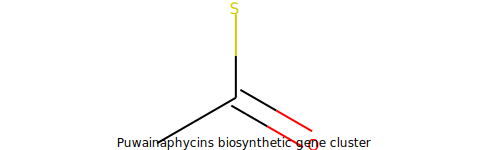

puwE
AIW82282.1
['KS', 'AT', 'PCP']


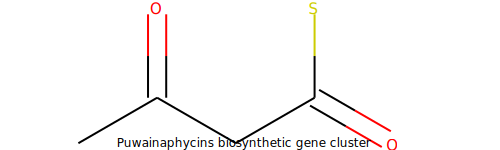

In [33]:
print(test_cluster_key)
print(test_cluster.description)
#print(list(test_cluster.subunits.values())[0].modules[0].operations[0].starter_name)
subunits = list(test_cluster.subunits.values())
chain = None
for subunit in subunits:
    print(subunit.name)
    print(subunit.id)
    for module in subunit.modules:
        print(str(list(module.domains.keys())))
        print(module.operations)
    chain = subunit.compute_product(chain)
    m_im = Draw.MolsToGridImage([chain], legends=[test_cluster.description], 
                                molsPerRow=1, subImgSize=(500,150), useSVG=True)
    display(m_im)

# Manually reorder clusters as needed

In [25]:
pruned_clusters['BGC0000097'].print_domains()

mlaE
['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlaF
['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlaG
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']
mlaD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlaB
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


In [26]:
# BE-14106
pruned_clusters['BGC0000029'].update_subunit_order(['becB', 'becD', 'becE', 'becF', 'becG'])
pruned_clusters['BGC0000029'].toggle_cyclization()
# Cremimycin
#pruned_clusters['BGC0000042'].update_subunit_order(['cmiP7', 'cmiP8', 'cmiP1', 'cmiP2', 'cmiP3', 'cmiP4', 'cmiP5', 'cmiP6'])
# Meilingmycin
pruned_clusters['BGC0000093'].pop_subunit('pks1')
pruned_clusters['BGC0000093'].pop_subunit('pks2')
# ML-449
pruned_clusters['BGC0000097'].update_subunit_order(['mlaB', 'mlaD', 'mlaE', 'mlaF', 'mlaG'])
pruned_clusters['BGC0000097'].toggle_cyclization()
# Nystatin
pruned_clusters['BGC0000115'].update_subunit_order(['nysA', 'nysB', 'nysC', 'nysI', 'nysJ', 'nysK'])
# Tiacumicin
pruned_clusters['BGC0000165'].pop_subunit('tiaB')
# Simocyclinone
pruned_clusters['BGC0001072'].update_subunit_order(['simC1A', 'simC1B', 'simC1C'])
# Brasilinolide
pruned_clusters['BGC0001381'].update_subunit_order(['nbrI', 'nbrJ', 'nbrK', 'nbrL', 'nbrG', 'nbrH'])

Old cyclization specification was True
New cyclization specification is False
Old cyclization specification was True
New cyclization specification is False


# Testing all clusters

In [27]:
pickle.dump(pruned_clusters, open('pruned_clusters_mibig.p', 'wb'))

(0/151): BGC0001125
Puwainaphycins biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
puwB
	['KS', 'AT', 'DH', 'cMT', 'ER', 'KR', 'ACP']
puwE
	['KS', 'AT', 'PCP']


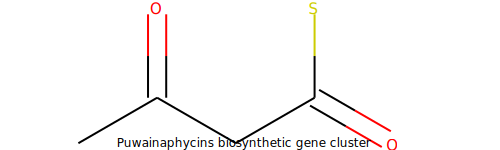

(1/151): BGC0000158
Tautomycetin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
ttnA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ttnB
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


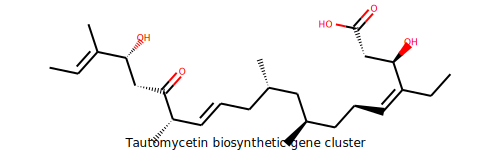

(2/151): BGC0001159
Marinopyrrole biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
mpy7
	['KS', 'AT', 'ACP']
mpy6
	['KS', 'AT', 'KR', 'ACP']


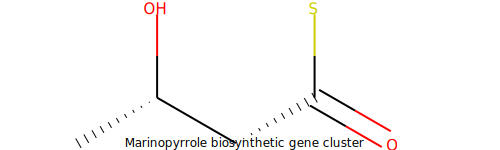

(3/151): BGC0000043
Curacin A biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
curM
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


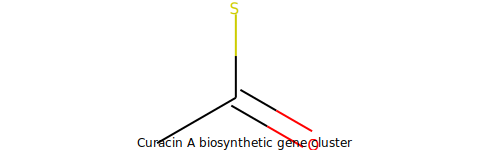

(4/151): BGC0000115
Nystatin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
nysA
	['KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
nysB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
nysC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nysI
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
nysJ
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nysK
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


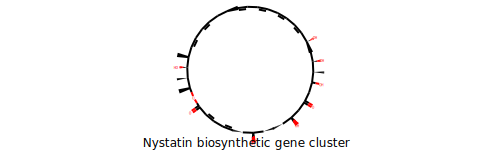

(5/151): BGC0000986
Dkxanthene biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
dkxG
	['KS', 'AT', 'DH', 'KR', 'ACP']
dkxH
	['KS', 'AT', 'DH', 'KR', 'ACP']
dkxI
	['KS', 'AT', 'DH', 'KR', 'ACP']
dkxN
	['KS', 'AT', 'DH', 'KR', 'ACP']


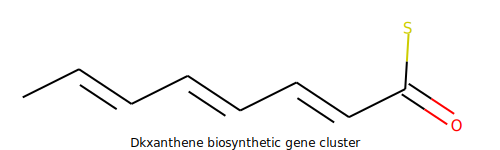

(6/151): BGC0000059
Filipin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
pteA1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
pteA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
pteA3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
pteA4
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
pteA5
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


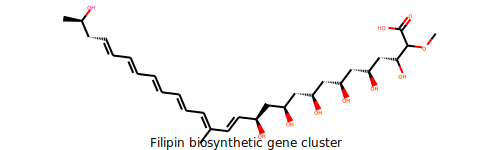

(7/151): BGC0001212
Nannocystin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Benzoyl-CoA
ncyA
	['KS', 'AT', 'DH', 'KR', 'ACP']
ncyB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
ncyC
	['KS', 'AT', 'oMT', 'KR', 'ACP']
ncyD
	['KS', 'AT', 'DH', 'KR', 'ACP']


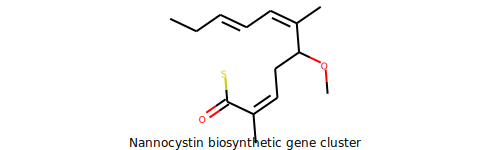

(8/151): BGC0000054
Erythromycin biosynthetic gene cluster
	Starter from antiSMASH: prop
	Starter from MiBiG: Not provided
eryAI
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
eryAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
eryAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


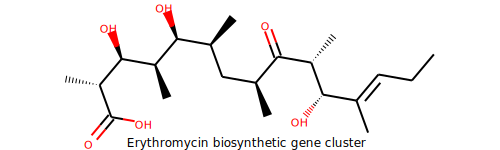

(9/151): BGC0000033
Calicheamicin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
calO5
	['KS', 'AT', 'DH', 'ACP']


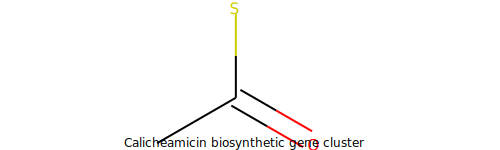

(10/151): BGC0000149
Spirangien biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
spiD
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
spiE
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
spiF
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
spiG
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
spiH
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
spiI
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
spiJ
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


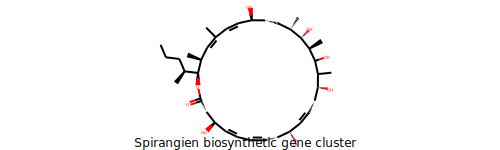

(11/151): BGC0000041
Coronafacic acid biosynthetic gene cluster
	Starter from antiSMASH: 2metbut
	Starter from MiBiG: Not provided
cfa6
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
cfa7
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


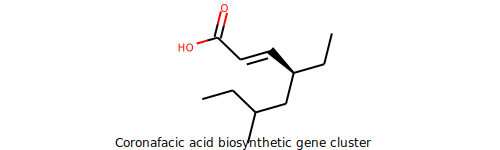

(12/151): BGC0001042
Sanglifehrin A biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
sfaE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
sfaF
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
sfaG
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
sfaH
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
sfaI
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


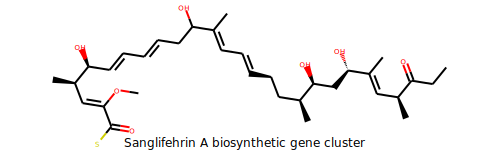

(13/151): BGC0000097
ML-449 biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Methylmalonyl-CoA
mlaB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
mlaD
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlaE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlaF
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlaG
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


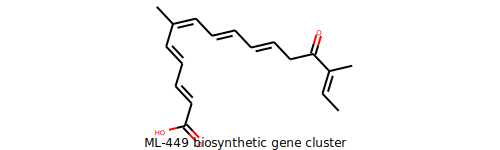

(14/151): BGC0000061
FR-008 biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
fscA
	['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
fscB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscF
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']


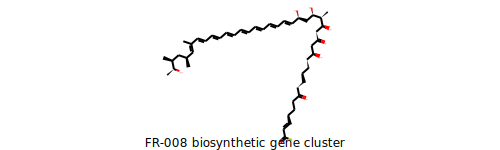

(15/151): BGC0000108
Natamycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
scnS0
	['KS', 'AT', 'ACP']
scnS1
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
scnS2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
scnS3
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
scnS4
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


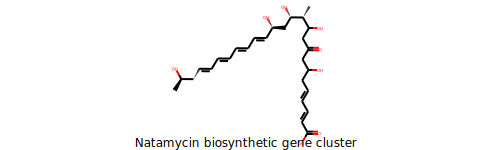

(16/151): BGC0000092
Megalomicin biosynthetic gene cluster
	Starter from antiSMASH: prop
	Starter from MiBiG: Not provided
megAI
	['AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
megAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
megAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


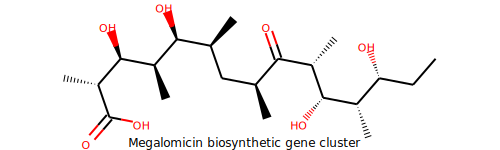

(17/151): BGC0001019
Microsclerodermins biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
mscA
	['KS', 'AT', 'DH', 'KR', 'ACP']


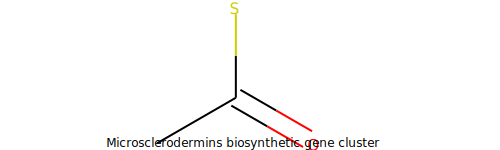

(18/151): BGC0000060
Fostriecin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
fosA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
fosB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
fosC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
fosD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
fosE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
fosF
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'Thioesterase']


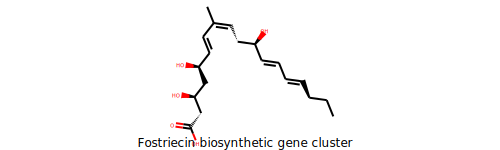

(19/151): BGC0000055
Erythromycin biosynthetic gene cluster
	Starter from antiSMASH: prop
	Starter from MiBiG: Propionyl-CoA
eryAI
	['AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
eryAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
eryAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


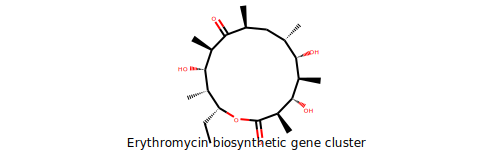

(20/151): BGC0001342
Thuggacin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
tugA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
tugB
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
tugC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
tugD
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


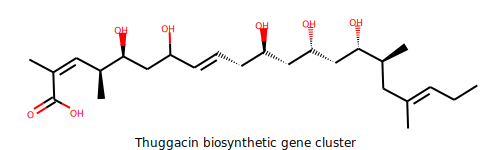

(21/151): BGC0000148
Spinosad biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
spnA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
spnB
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
spnC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
spnD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
spnE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


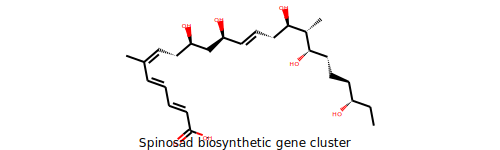

(22/151): BGC0000072
Gulmirecin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
gulA
	['KS', 'AT', 'DH', 'KR', 'ACP']
gulB
	['KS', 'AT', 'KR', 'ACP']
gulC
	['KS', 'AT', 'DH', 'KR', 'ACP']
gulD
	['KS', 'AT', 'KR', 'ACP']
gulE
	['KS', 'AT', 'ACP']
gulF
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


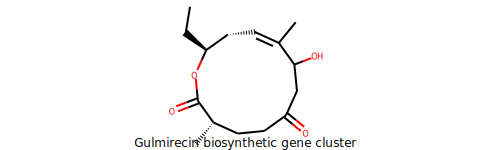

(23/151): BGC0000166
Tylactone biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
tylG
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
tylG_1
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
tylG_2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
tylG_3
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
tylG_4
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


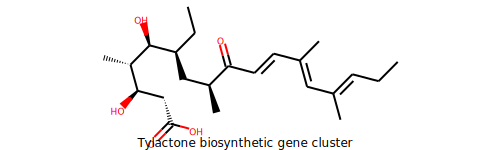

(24/151): BGC0000106
Naphthomycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
natA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
natB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
natC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
natD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
natE
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


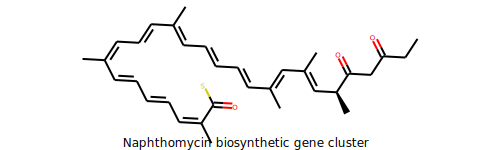

(25/151): BGC0000079
Indanomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
idmL
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
idmM
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
idmN
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
idmO
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
idmP
	['KS', 'AT', 'KR', 'ACP']


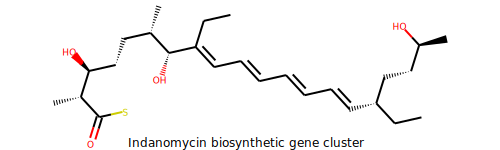

(26/151): BGC0000978
Cylindrospermopsin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
cyrD
	['KS', 'AT', 'DH', 'KR', 'ACP']
cyrF
	['KS', 'AT', 'ACP']
cyrB
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
cyrE
	['KS', 'AT', 'DH', 'KR', 'ACP']
cyrC
	['KS', 'AT', 'KR', 'ACP']


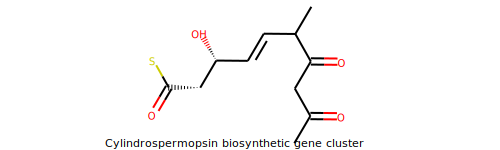

(27/151): BGC0001066
Kendomycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Other
ken12
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


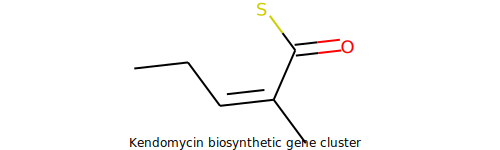

(28/151): BGC0000069
Gephyronic acid biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
gphG
	['KS', 'AT', 'cMT', 'KR', 'ACP']
gphH
	['KS', 'AT', 'cMT', 'ACP']
gphI
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
gphJ
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


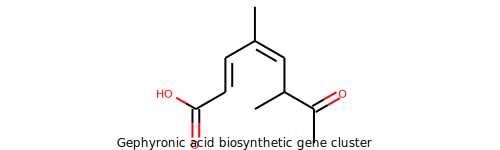

(29/151): BGC0001056
Zeamine biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Acetyl-CoA
zmn18
	['KS', 'AT', 'KR', 'PCP']


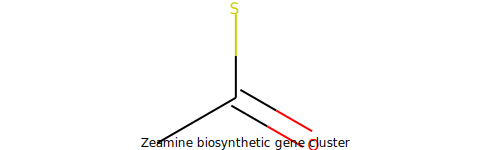

(30/151): BGC0001354
U-68204 biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
stuB
	['KS', 'AT', 'DH', 'KR', 'ACP']


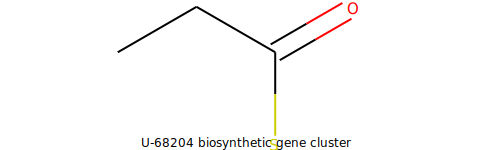

(31/151): BGC0000167
Vicenistatin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
vinP1
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
vinP2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
vinP3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
vinP4
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


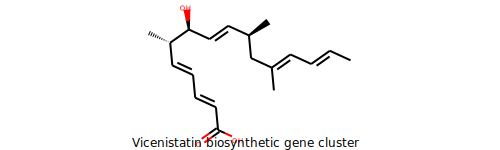

(32/151): BGC0000113
Niddamycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
nidA1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nidA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nidA3
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nidA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
nidA5
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


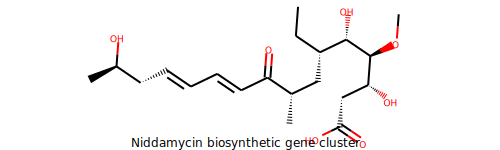

(33/151): BGC0000002
Aculeximycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
acuAI
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
acuAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
acuAIII
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
acuAIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
acuAV
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
acuAVI
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
acuAVII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
ac

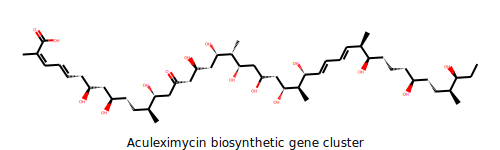

(34/151): BGC0000345
Eponemycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
epnH
	['KS', 'AT', 'cMT', 'PCP']


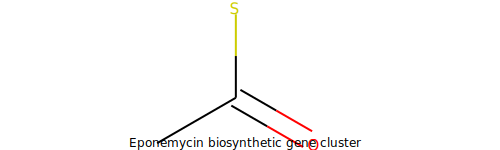

(35/151): BGC0000128
Pyoluteorin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
pltB
	['KS', 'AT', 'ACP']


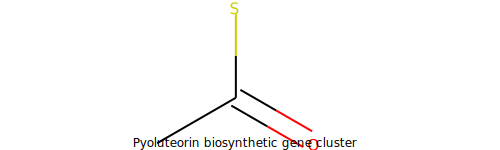

(36/151): BGC0000038
Coelimycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
SCO6275
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
SCO6274
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
SCO6273
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']


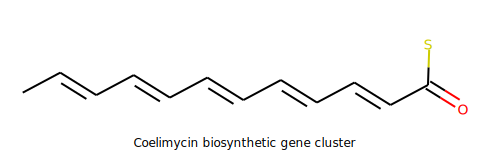

(37/151): BGC0000102
Mycinamicin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
mycAI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mycAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mycAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
mycAIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
mycAV
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


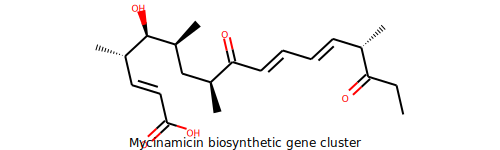

(38/151): BGC0000078
Incednine biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
idnP1
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
idnP2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
idnP3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
idnP4
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
idnP5
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


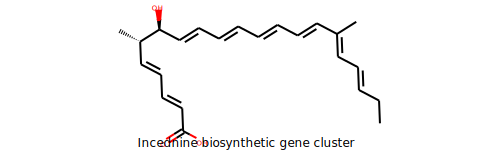

(39/151): BGC0000132
Pyrrolomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
dox24
	['KS', 'AT', 'DH', 'KR', 'ACP']


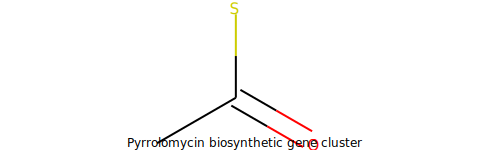

(40/151): BGC0000023
Aurafuron biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: 3-Methylbutyryl-CoA
aufC
	['KS', 'AT', 'DH', 'KR', 'ACP']
aufD
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
aufE
	['KS', 'AT', 'ER', 'KR', 'ACP']
aufF
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
aufG
	['KS', 'AT', 'DH', 'ER', 'ACP']
aufI
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


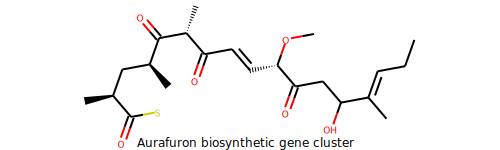

(41/151): BGC0000165
Tiacumicin B biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Ethylmalonyl-CoA
tiaA1
	['AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
tiaA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
tiaA3
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
tiaA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


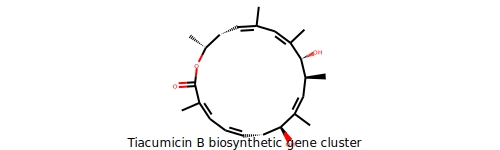

(42/151): BGC0000066
Geldanamycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
gdmAI
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
gdmAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
gdmAIII
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


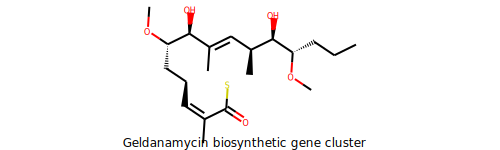

(43/151): BGC0000994
FK520 biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
fkbA
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'ACP']
fkbB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
fkbC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']


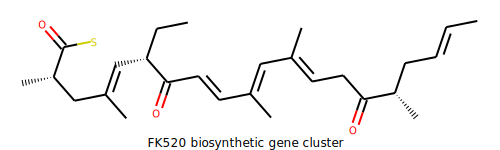

(44/151): BGC0000990
Epothilone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	['KS', 'AT', 'ER', 'ACP']
epoC
	['KS', 'AT', 'DH', 'KR', 'ACP']
epoD
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
epoE
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
epoF
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


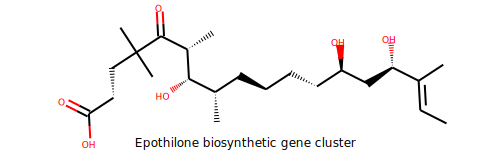

(45/151): BGC0000963
Bleomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
blmVIII
	['KS', 'AT', 'cMT', 'KR', 'PCP']


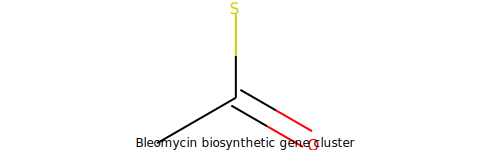

(46/151): BGC0001288
Maklamicin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
makA1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
makA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
makA3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
makA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']


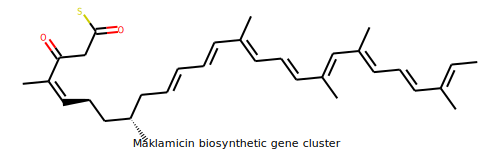

(47/151): BGC0000035
Chalcomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
chmGI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
chmGII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
chmGIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
chmGIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
chmGV
	['KS', 'AT', 'ACP', 'Thioesterase']


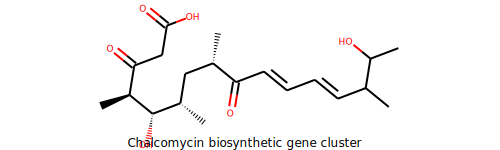

(48/151): BGC0000972
Colibactin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
clbB
	['KS', 'AT', 'KR', 'DH', 'ER', 'PCP']


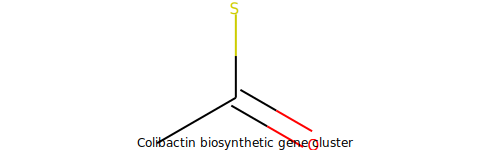

(49/151): BGC0000380
Leupyrrin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
leuA
	['KS', 'AT', 'DH', 'KR', 'ACP']
leuB
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
leuD
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']


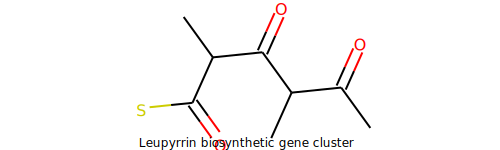

(50/151): BGC0000085
Lankamycin biosynthetic gene cluster
	Starter from antiSMASH: 2metbut
	Starter from MiBiG: Not provided
lkmAI
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
lkmAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
lkmAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


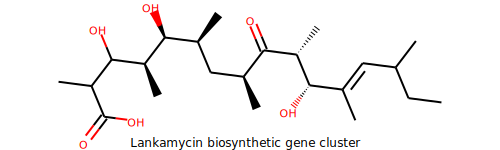

(51/151): BGC0000123
Phoslactomycin B biosynthetic gene cluster
	Starter from antiSMASH: CHC-CoA
	Starter from MiBiG: Not provided
plm1
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
plm2-3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
plm4
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
plm5
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
plm6
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
plm7
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'Thioesterase']


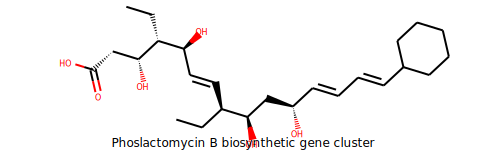

(52/151): BGC0000042
Cremimycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
cmiP1
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
cmiP4
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
cmiP5
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
cmiP6
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']
cmiP7
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cmiP8
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
PREDICTION WARNING: CCCC(=O)C(C)CCCCC(O)CC(=O)CC=CC(=O)O
(53/151): BGC0001011
Meridamycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
merA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
merB
	['PKS_Dock

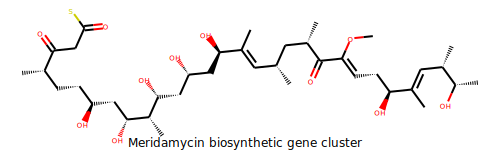

(54/151): BGC0000073
Halstoctacosanolide biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
hlsA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
hlsB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
hlsC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
hlsD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
hlsE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
hlsF
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
hlsG
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


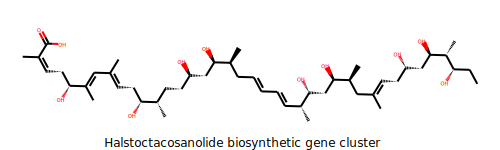

(55/151): BGC0000138
Rimocidin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
rimA
	['KS', 'AT', 'ACP']


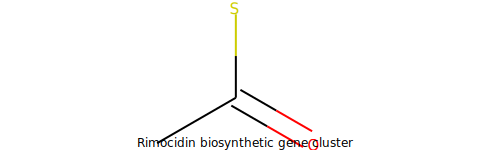

(56/151): BGC0001053
Tubulysin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
tubD
	['KS', 'AT', 'KR', 'DH', 'ER', 'PCP']
tubF
	['KS', 'AT', 'KR', 'cMT', 'DH', 'ER', 'PCP', 'Thioesterase']


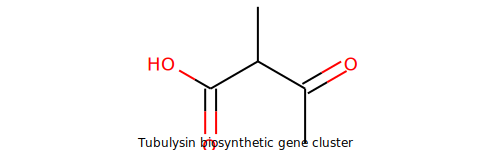

(57/151): BGC0001396
Aldgamycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
almHI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
almHII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
almHIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
almHIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
almHV
	['KS', 'AT', 'ACP', 'Thioesterase']


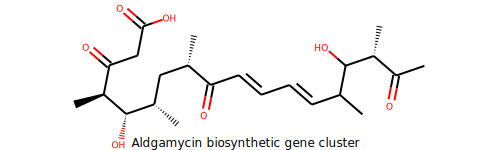

(58/151): BGC0000091
Marineosin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
marL
	['KS', 'AT', 'ACP']


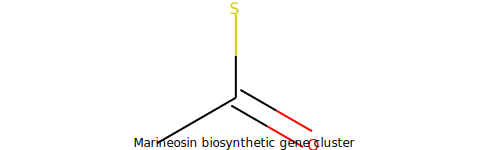

(59/151): BGC0001231
Microsclerodermins biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
mscA
	['KS', 'AT', 'DH', 'KR', 'ACP']


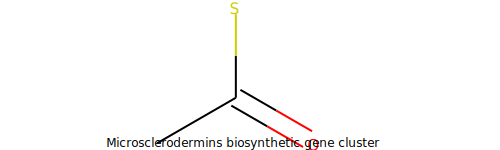

(60/151): BGC0001065
Herboxidiene biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
herB
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
herC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
herD
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


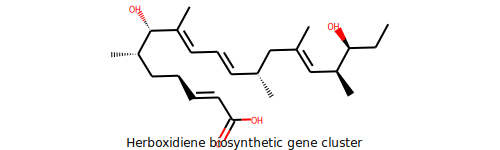

(61/151): BGC0001359
PM100117 / PM100118 biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
gonP1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
gonP2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
gonP3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
gonP4
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
gonP5
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']


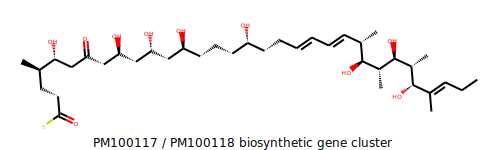

(62/151): BGC0001235
Antalid biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
antA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


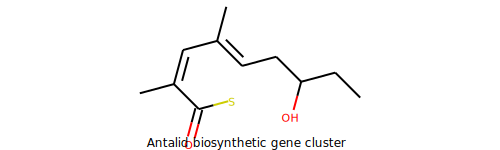

(63/151): BGC0001063
Undecylprodigiosin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
SCO5892
	['KS', 'AT', 'ACP']


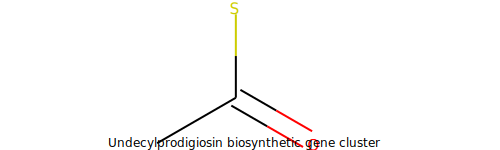

(64/151): BGC0000014
Ambruticin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
ambA
	['KS', 'AT', 'ACP']
ambB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ambC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
ambD
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
ambE
	['KS', 'AT', 'DH', 'KR', 'ACP']
ambH
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


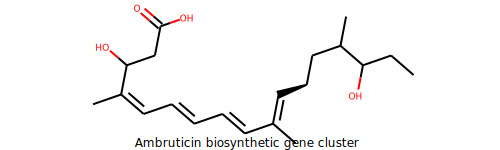

(65/151): BGC0000080
Jerangolid biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
jerA
	['KS', 'AT', 'ACP']
jerB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
jerC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
jerD
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
jerE
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'ACP', 'Thioesterase']


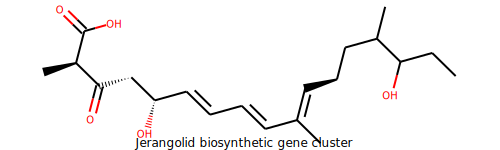

(66/151): BGC0000147
Soraphen biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Benzoyl-CoA
sorA
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
sorB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']
PREDICTION WARNING: Sanitization error: Explicit valence for atom # 2 O, 3, is greater than permitted
(67/151): BGC0001048
Tallysomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
tlmVIII
	['KS', 'AT', 'KR', 'PCP']


RDKit ERROR: [23:10:11] Explicit valence for atom # 2 O, 3, is greater than permitted


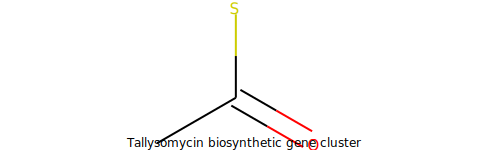

(68/151): BGC0000087
Lasalocid biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
lasAI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
lasAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lasAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
lasAIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lasAV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lasAVI
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
lasAVII
	['KS', 'AT', 'ACP', 'Thioesterase']


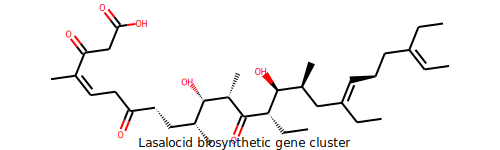

(69/151): BGC0000116
Nystatin-like Pseudonocardia polyene biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
cppA
	['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
cppB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
cppC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cppI
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
cppJ
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cppK
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


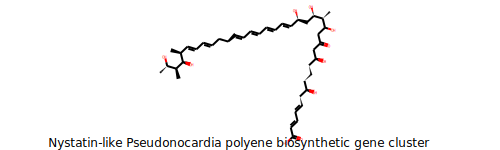

(70/151): BGC0000145
Salinosporamide A biosynthetic gene cluster
	Starter from antiSMASH: cemal
	Starter from MiBiG: Not provided
salA
	['KS', 'AT', 'ACP', 'Condensation_LCL']


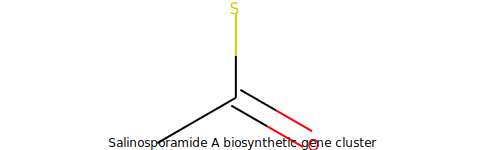

(71/151): BGC0001022
Myxalamid biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
mxaC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
mxaD
	['KS', 'AT', 'DH', 'KR', 'ACP']
mxaE
	['KS', 'AT', 'DH', 'KR', 'ACP']
mxaF
	['KS', 'AT', 'DH', 'KR', 'ACP']


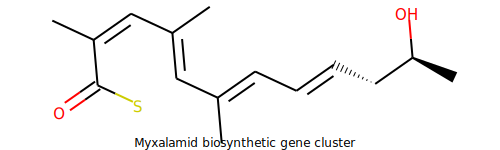

(72/151): BGC0001046
Streptolydigin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Acetyl-CoA
slgA1
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
slgA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
slgA3
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']


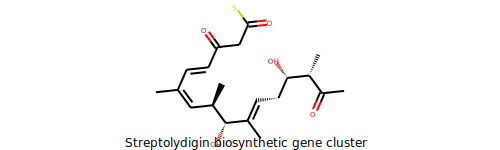

(73/151): BGC0001039
Pyridomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
pyrF
	['KS', 'AT', 'cMT', 'PCP']


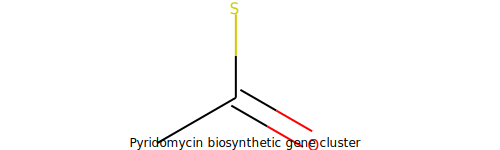

(74/151): BGC0000029
BE-14106 biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
becB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
becD
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
becE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
becF
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
becG
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


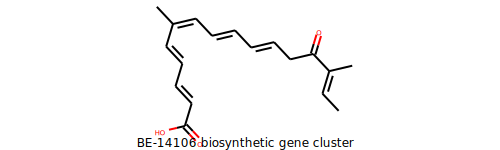

(75/151): BGC0001355
U-68204 biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
ssuB
	['KS', 'AT', 'DH', 'KR', 'ACP']


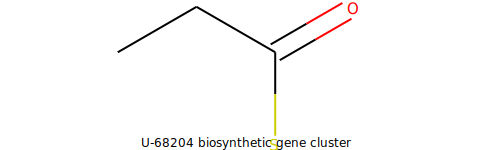

(76/151): BGC0000130
Pyrrolomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
pyr24
	['KS', 'AT', 'DH', 'KR', 'ACP']
pyr25
	['KS', 'AT', 'ACP']


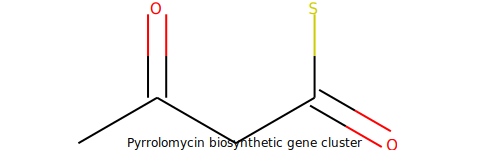

(77/151): BGC0000100
Monensin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
monAI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAVI
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAVII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
monAVIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


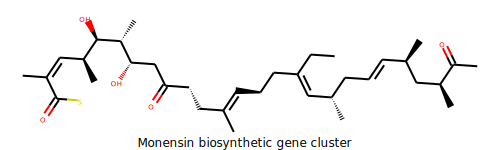

(78/151): BGC0000988
Epothilone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	['KS', 'AT', 'ER', 'ACP']
epoB
	['KS', 'AT', 'DH', 'KR', 'ACP']
epoC
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
epoD
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
epoE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


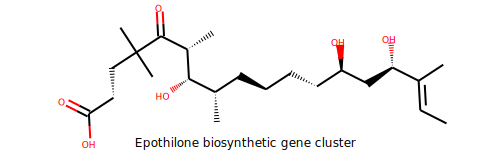

(79/151): BGC0000103
Mycolactone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
mlsA1
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
mlsA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
mlsB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


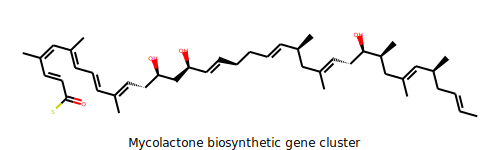

(80/151): BGC0001021
Mycobactin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
mbtD
	['AT', 'KR', 'ACP']


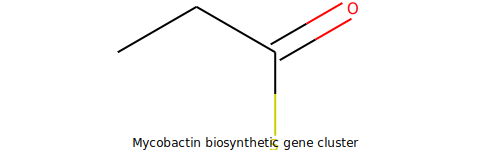

(81/151): BGC0000047
Dihydrochalcomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
gerSI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
gerSII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
gerSIII
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
gerSIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
gerSV
	['KS', 'AT', 'ACP', 'Thioesterase']


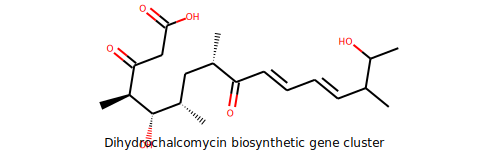

(82/151): BGC0000125
Pimaricin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
pimS0
	['KS', 'AT', 'ACP']
pimS1
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
pimS2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
pimS3
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
pimS4
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


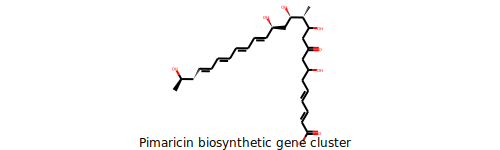

(83/151): BGC0000998
Guadinomine biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
gdnE
	['KS', 'AT', 'DH', 'KR', 'ACP']
gdnF
	['KS', 'AT', 'KR', 'ACP']
gdnG
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
gdnH
	['KS', 'AT', 'ACP']


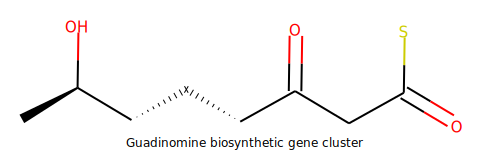

(84/151): BGC0000159
Tautomycin biosynthetic gene cluster
	Starter from antiSMASH: isobut
	Starter from MiBiG: Isobutyryl-CoA
ttmJ
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
ttmI
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ttmH
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


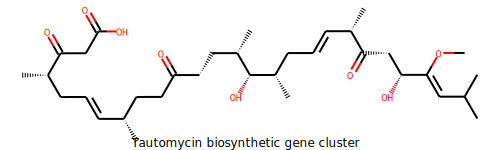

(85/151): BGC0001017
Microcystin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
mcyG
	['KS', 'AT', 'cMT', 'KR', 'ACP']


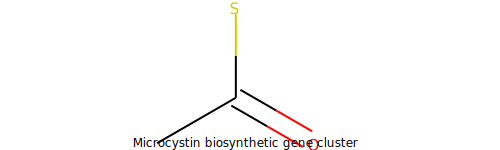

(86/151): BGC0001002
Jawsamycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
jaw4
	['KS', 'AT', 'DH', 'ACP']


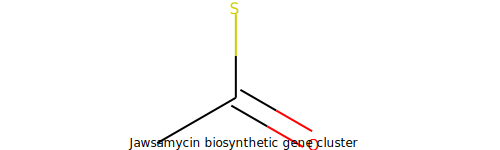

(87/151): BGC0000989
Epothilone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	['KS', 'AT', 'ER', 'ACP']
epoB
	['KS', 'AT', 'DH', 'KR', 'ACP']
epoC
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
epoD
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
epoE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


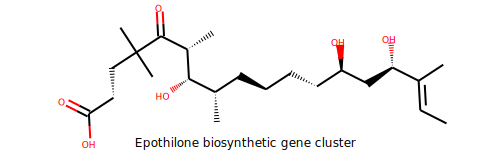

(88/151): BGC0001010
Melithiazol biosynthetic gene cluster
	Starter from antiSMASH: isobut
	Starter from MiBiG: Isobutyryl-CoA
melB
	['KS', 'AT', 'ACP']
melD
	['KS', 'AT', 'DH', 'KR', 'ACP']
melE
	['KS', 'AT', 'oMT', 'KR', 'ACP']
melF
	['KS', 'AT', 'oMT', 'ACP']


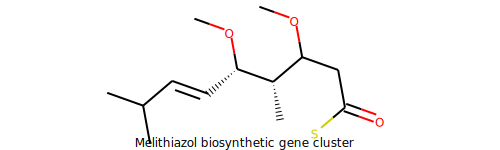

(89/151): BGC0001236
Thiotetroamide biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
ttmH
	['KS', 'AT', 'DH', 'KR', 'ACP']


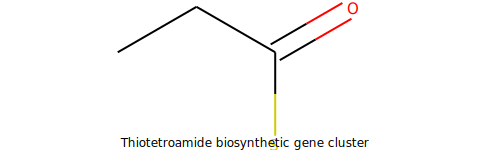

(90/151): BGC0000021
Apoptolidin biosynthetic gene cluster
	Starter from antiSMASH: mxmal
	Starter from MiBiG: Not provided
apoS1
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
apoS2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
apoS4
	['AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
apoS5
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
apoS6
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
apoS7
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
apoS8
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


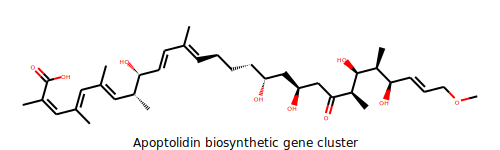

(91/151): BGC0000105
Nanchangmycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
nanA1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA11
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA5
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA6
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA7
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
nanA8
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


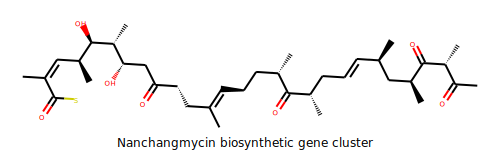

(92/151): BGC0000032
Calcimycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
SchA1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
SchA2
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
SchA4
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
SchA5
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']


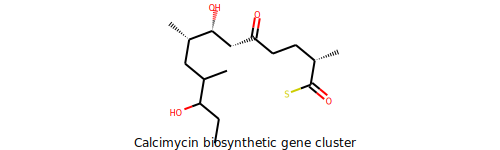

(93/151): BGC0001072
Simocyclinone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Unknown
simC1A
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
simC1B
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
simC1C
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP', 'Thioesterase']


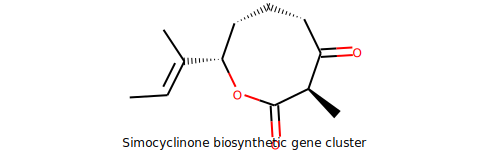

(94/151): BGC0000126
Pladienolide biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
pldAI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
pldAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
pldAIII
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
pldAIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'Thioesterase']


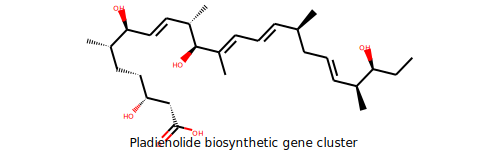

(95/151): BGC0000109
Nemadectin biosynthetic gene cluster
	Starter from antiSMASH: 2metbut
	Starter from MiBiG: Not provided
nemA1-1
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nemA1-2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nemA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nemA3
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nemA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


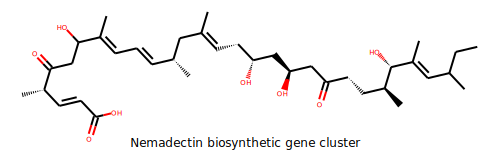

(96/151): BGC0001051
Thuggacin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
tgaA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
tgaB
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
tgaC
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


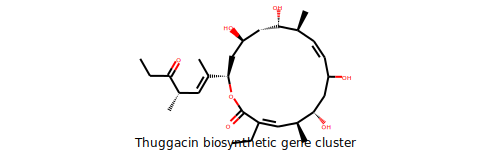

(97/151): BGC0000969
Chondramide biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
cmdA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
cmdB
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


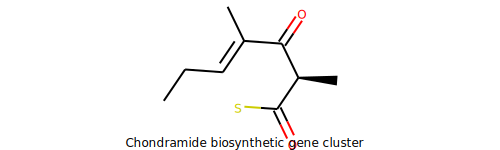

(98/151): BGC0000084
Laidlomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
ladSI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
ladSII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ladSIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ladSIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ladSV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ladSVI
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
ladSVII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
ladSVIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


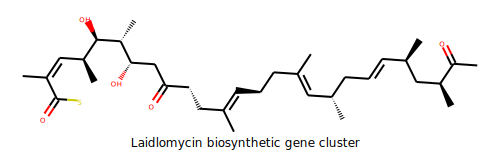

(99/151): BGC0000068
Geldanamycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
gdmPKS
	['KS', 'AT', 'DH', 'KR', 'ACP']


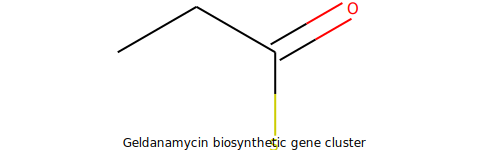

(100/151): BGC0001303
Lobosamide biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
lobB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lobC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lobD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
lobR
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


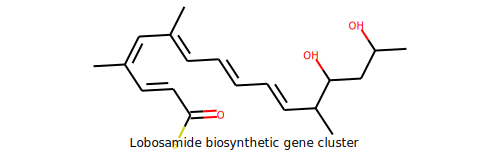

(101/151): BGC0000110
Neoaureothin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: p-Nitrobenzoate
norA
	['KS', 'AT', 'DH', 'KR', 'ACP']
norA_
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
norB
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']


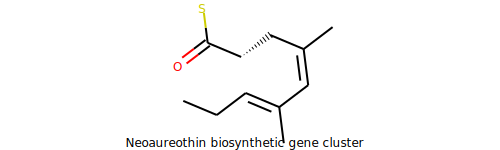

(102/151): BGC0000024
Aureothin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: p-Nitrobenzoate
aurA
	['KS', 'AT', 'DH', 'KR', 'ACP']
aurB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']


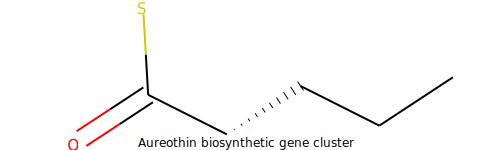

(103/151): BGC0001287
Chaxamycin A / chaxamycin B / chaxamycin C / chaxamycin D biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
cxmA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
cxmB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
cxmC
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cxmD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cxmE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


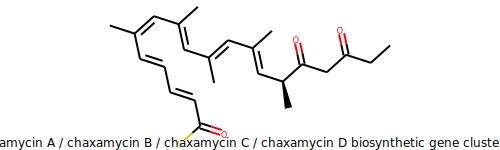

(104/151): BGC0000981
Cylindrospermopsin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
cyrB
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
cyrC
	['KS', 'AT', 'KR', 'ACP']
cyrD
	['KS', 'AT', 'DH', 'KR', 'ACP']
cyrE
	['KS', 'AT', 'DH', 'KR', 'ACP']
cyrF
	['KS', 'AT', 'ACP']


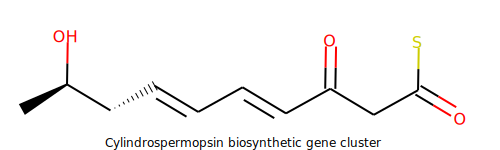

(105/151): BGC0001009
Melithiazol biosynthetic gene cluster
	Starter from antiSMASH: isobut
	Starter from MiBiG: Not provided
melB
	['KS', 'AT', 'ACP']
melD
	['KS', 'AT', 'DH', 'KR', 'ACP']
melE
	['KS', 'AT', 'oMT', 'KR', 'ACP']
melF
	['KS', 'AT', 'oMT', 'ACP']


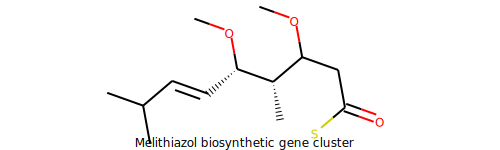

(106/151): BGC0000127
Pyoluteorin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
pltB
	['KS', 'AT', 'ACP']


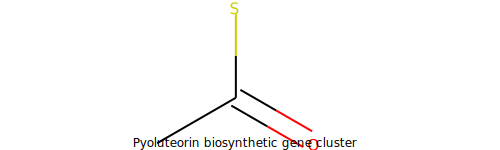

(107/151): BGC0000974
Crocacin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
croA
	['KS', 'AT', 'oMT', 'KR', 'ACP']
croB
	['KS', 'AT', 'oMT', 'KR', 'ACP']
croC
	['KS', 'AT', 'DH', 'KR', 'ACP']
croI
	['KS', 'AT', 'DH', 'KR', 'ACP']
croJ
	['KS', 'AT', 'DH', 'KR', 'ACP']


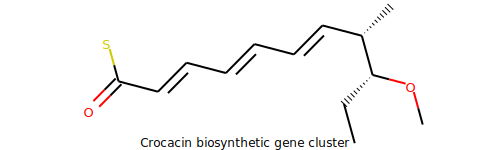

(108/151): BGC0000118
Pactamycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
pctS
	['KS', 'AT', 'DH', 'KR', 'ACP']


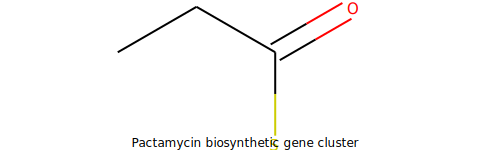

(109/151): BGC0001012
Meridamycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
merA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
merB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
merC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


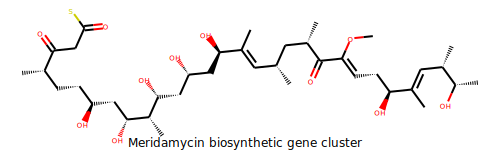

(110/151): BGC0001004
Lobophorin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Malonyl-CoA
lobA1
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
lobA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
lobA3
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
lobA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


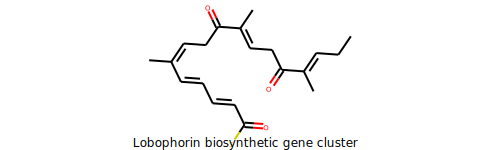

(111/151): BGC0000971
Cinnabaramide biosynthetic gene cluster
	Starter from antiSMASH: cemal
	Starter from MiBiG: Acetyl-CoA
cinA
	['KS', 'AT', 'ACP', 'Condensation_LCL']


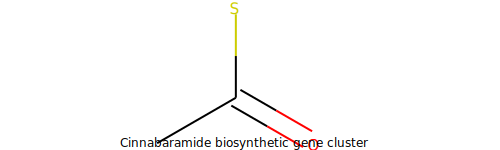

(112/151): BGC0000051
Ebelactone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
ebeA
	['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
ebeB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ebeC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
ebeF
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
ebeG
	['KS', 'AT', 'KR', 'ACP']


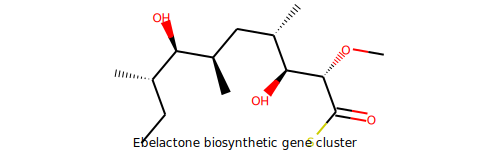

(113/151): BGC0000058
FD-891 biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
gfsA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
gfsB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
gfsC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
gfsD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
gfsE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


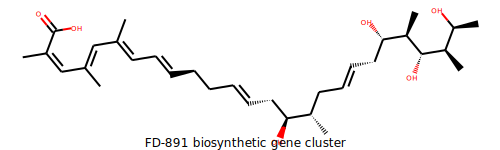

(114/151): BGC0001003
Lipomycin biosynthetic gene cluster
	Starter from antiSMASH: isobut
	Starter from MiBiG: Isobutyryl-CoA
lipPks1
	['AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lipPks2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
lipPks3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
lipPks4
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'ACP']


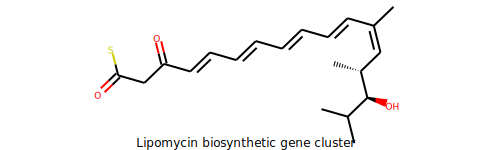

(115/151): BGC0001040
Rapamycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
rapA
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
rapB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
rapC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'ACP']


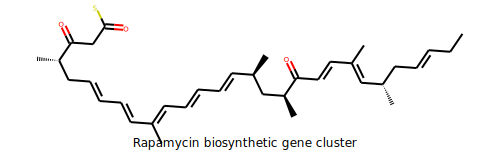

(116/151): BGC0001172
Chlorizidine A biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
clz6
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
clz7
	['KS', 'AT', 'ACP']


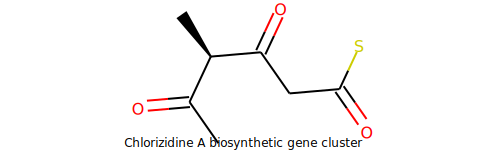

(117/151): BGC0001023
Myxochromide biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Acetyl-CoA
mchA
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


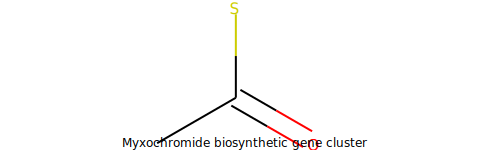

(118/151): BGC0000015
Amphotericin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
amphA
	['KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
amphB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
amphC
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
amphI
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
amphJ
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
amphK
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


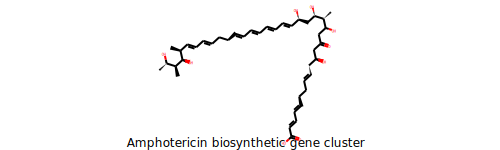

(119/151): BGC0001024
Myxothiazol biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: 3-Methylbutyryl-CoA
mtaB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
mtaD
	['KS', 'AT', 'DH', 'KR', 'ACP']
mtaE
	['KS', 'AT', 'oMT', 'KR', 'ACP']
mtaF
	['KS', 'AT', 'oMT', 'ACP']


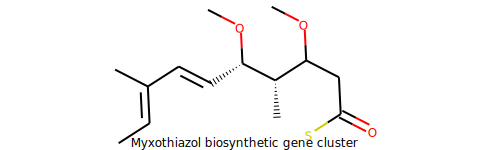

(120/151): BGC0000135
Reveromycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
revA
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
revB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
revC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
revD
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


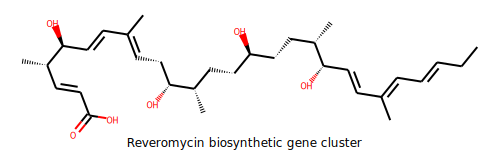

(121/151): BGC0000086
Lasalocid biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
lsd11
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
lsd12
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lsd13
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
lsd14
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lsd15
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
lsd16
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
lsd17
	['KS', 'AT', 'ACP', 'Thioesterase']


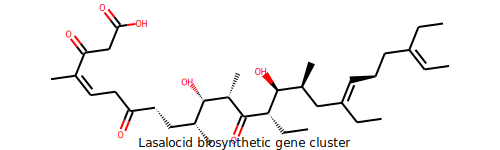

(122/151): BGC0001027
Nocobactin NA biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
nbtC
	['AT', 'KR', 'ACP']


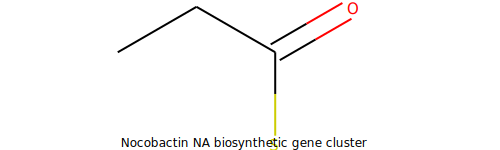

(123/151): BGC0000143
Salinomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
salA
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']


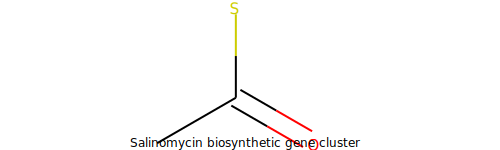

(124/151): BGC0000346
Epoxomicin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
epxE
	['KS', 'AT', 'cMT', 'PCP', 'Thioesterase']


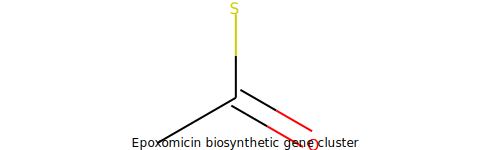

(125/151): BGC0001293
Cyclizidine biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
cycB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
cycC
	['AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cycE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
cycF
	['AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


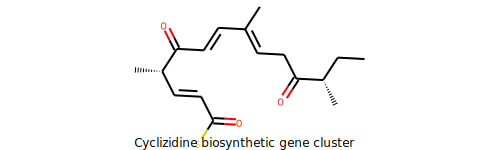

(126/151): BGC0000018
Angolamycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
angAI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
angAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
angAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
angAIV
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
angAV
	['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


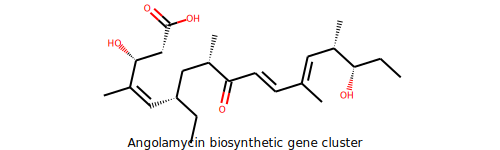

(127/151): BGC0000141
Rubradirin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
rubA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
rubB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


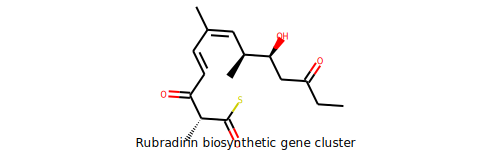

(128/151): BGC0001015
Microcystin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
mcyD
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
mcyG
	['KS', 'AT', 'cMT', 'KR', 'ACP']


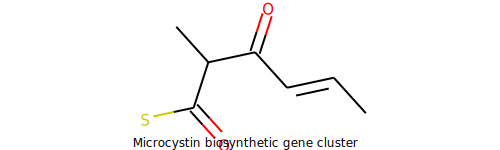

(129/151): BGC0000031
Borrelidin biosynthetic gene cluster
	Starter from antiSMASH: trans-1,2-CPDA
	Starter from MiBiG: Trans-cyclopentane-(1R,2R)-dicarboxylic acid
borA1
	['AT', 'ACP', 'PKS_Docking_Cterm']
borA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
borA3
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
borA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
borA5
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
borA6
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'Thioesterase']


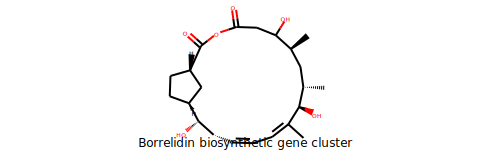

(130/151): BGC0000090
Macbecin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: 3,5-AHBA-CoA
mbcAI
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
mbcAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
mbcAIII
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


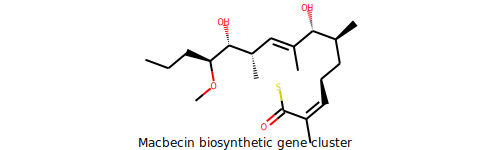

(131/151): BGC0000074
Herbimycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
hbmAI
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
hbmAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
hbmAIII
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


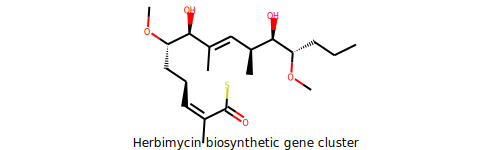

(132/151): BGC0001296
Streptazone E biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
stzB
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
stzC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
stzD
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']


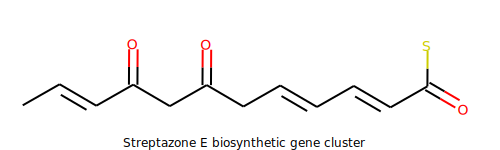

(133/151): BGC0000075
Hygrocin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
hgcA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
hgcB
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
hgcC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
hgcD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
hgcE
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


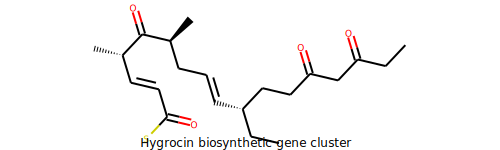

(134/151): BGC0000991
Epothilone biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	['KS', 'AT', 'ER', 'ACP']
epoC
	['KS', 'AT', 'DH', 'KR', 'ACP']
epoD
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
epoE
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
epoF
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


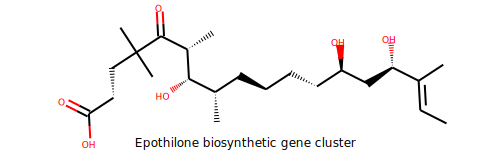

(135/151): BGC0001237
Thiolactomycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
tlmH
	['KS', 'AT', 'DH', 'KR', 'ACP']


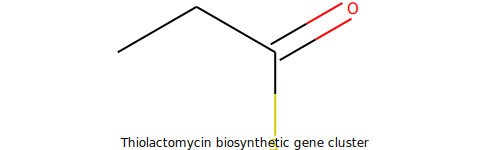

(136/151): BGC0000020
Ansamitocin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
asmA
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
asmB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
asmC
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
asmD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


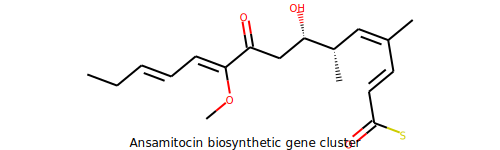

(137/151): BGC0000017
Anatoxin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
anaE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
anaF
	['KS', 'AT', 'DH', 'KR', 'ACP']


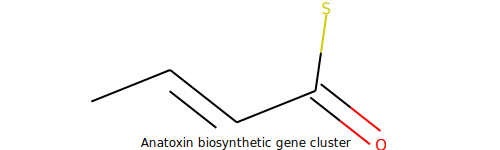

(138/151): BGC0000982
Cystothiazole A biosynthetic gene cluster
	Starter from antiSMASH: isobut
	Starter from MiBiG: Not provided
ctaB
	['KS', 'AT', 'ACP']
ctaD
	['KS', 'AT', 'DH', 'KR', 'ACP']
ctaE
	['KS', 'AT', 'oMT', 'KR', 'ACP']
ctaF
	['KS', 'AT', 'oMT', 'ACP']


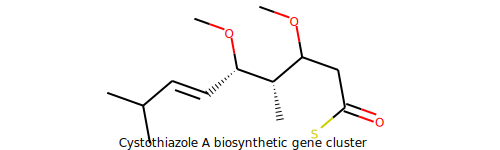

(139/151): BGC0001038
Pyralomicin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Other
prlP
	['KS', 'AT', 'KR', 'ACP']
prlQ
	['KS', 'AT', 'ACP']


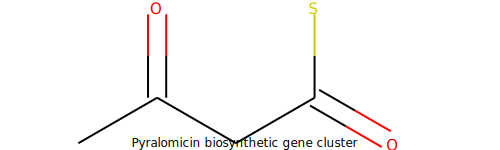

(140/151): BGC0001381
Brasilinolide biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
nbrI
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nbrJ
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
nbrK
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
nbrL
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
nbrG
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
nbrH
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


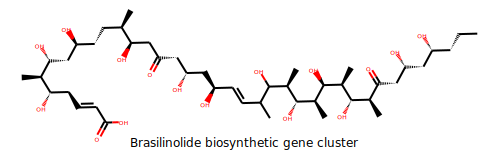

(141/151): BGC0000094
Methymycin / pikromycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Malonyl-CoA
pikAI
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
pikAII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
pikAIII
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
pikAIV
	['KS', 'AT', 'ACP', 'Thioesterase']


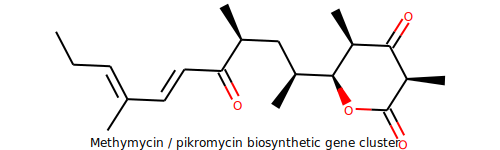

(142/151): BGC0000001
Abyssomicin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Acetyl-CoA
abyB1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
abyB2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
abyB3
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']


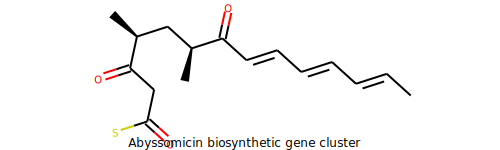

(143/151): BGC0001047
Syringolin A biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
sylD
	['KS', 'AT', 'DH', 'KR', 'PCP', 'Thioesterase']


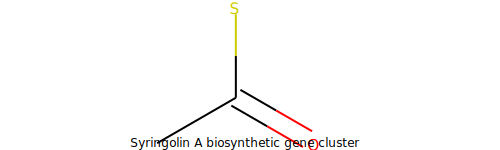

(144/151): BGC0000140
RK-682 biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
rkC
	['KS', 'AT', 'ACP']


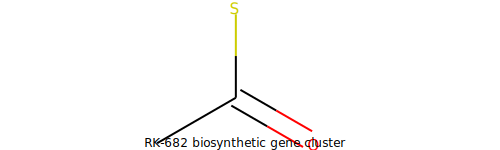

(145/151): BGC0000144
Salinomycin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
slnA1
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
slnA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
slnA3
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
slnA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
slnA5
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
slnA6
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
slnA7
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
slnA8
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']


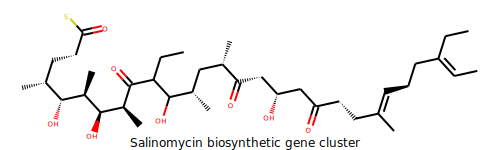

(146/151): BGC0000034
Candicidin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
fscA
	['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
fscB
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscC
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscE
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
fscF
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'AC

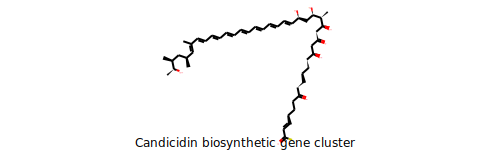

(147/151): BGC0000153
Stigmatellin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
stiA
	['KS', 'AT', 'DH', 'KR', 'ACP']
stiB
	['KS', 'AT', 'KR', 'ACP']
stiC
	['KS', 'AT', 'DH', 'KR', 'ACP']
stiD
	['KS', 'AT', 'oMT', 'KR', 'ACP']
stiE
	['KS', 'AT', 'oMT', 'KR', 'ACP']
stiF
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
stiG
	['KS', 'AT', 'DH', 'ACP']
stiH
	['KS', 'AT', 'KR', 'ACP']


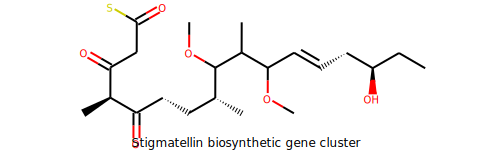

(148/151): BGC0000136
Rifamycin biosynthetic gene cluster
	Starter from antiSMASH: mmal
	Starter from MiBiG: Not provided
rifA
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
rifB
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
rifC
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
rifD
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
rifE
	['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']


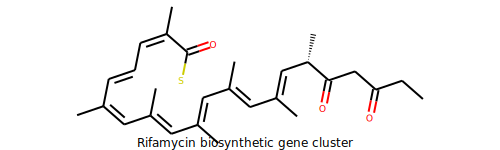

(149/151): BGC0000093
Meilingmycin biosynthetic gene cluster
	Starter from antiSMASH: 2metbut
	Starter from MiBiG: Not provided
meiA1
	['AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
meiA2
	['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
meiA3
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
meiA4
	['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


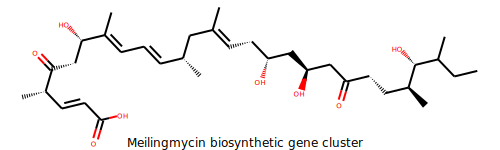

(150/151): BGC0000997
Glidobactin biosynthetic gene cluster
	Starter from antiSMASH: mal
	Starter from MiBiG: Not provided
glbC
	['KS', 'AT', 'DH', 'KR', 'PCP', 'Thioesterase']


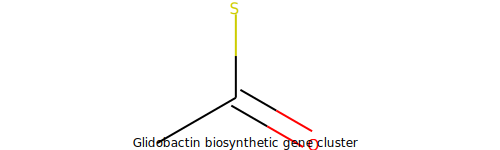

In [28]:
valid = 0
nclusters = len(pruned_clusters)

# Save invalid clusters so we can take a closer look
pruned_clusters_invalid = {}

for icluster,test_cluster_key in enumerate(list(pruned_clusters.keys())):
    try:
        test_cluster = pruned_clusters[test_cluster_key]
        print('(%d/%d): %s' %(icluster, nclusters, test_cluster_key))
        print(test_cluster.description)
        print('\tStarter from antiSMASH: %s' %(list(test_cluster.subunits.values())[0].modules[0].operations[0].starter_name))
        with open(os.path.join(file_path, test_cluster_key + '.json')) as json_file:            
            mibig_data = json.load(json_file)
            try:
                mibig_starter = mibig_data['general_params']['Polyketide']['starter_unit']
            except KeyError:
                mibig_starter = 'Not provided'
        print('\tStarter from MiBiG: %s' %(mibig_starter))        
        subunits = list(test_cluster.subunits.values())
        for subunit in subunits:
            print(subunit.name)
            for module in subunit.modules:
                print('\t' + str(list(module.domains.keys())))
        m = test_cluster.compute_product(None)
        m_im = Draw.MolsToGridImage([m], legends=[test_cluster.description], 
                                    molsPerRow=1, subImgSize=(500,150), useSVG=True)
        display(m_im)
        valid += 1
    except Exception as e:
        print('PREDICTION WARNING: %s' %(e))
        
        # Add to dictionary of invalid clusters
        pruned_clusters_invalid[test_cluster_key] = test_cluster

In [29]:
print(valid)

149


In [30]:
# Save invalid clusters so we can take a closer look
pruned_clusters_invalid = {}

for icluster,test_cluster_key in enumerate(list(pruned_clusters_invalid.keys())):
    try:
        test_cluster = pruned_clusters[test_cluster_key]
        print('(%d/%d): %s' %(icluster, nclusters, test_cluster_key))
        print('\tStarter from antiSMASH: %s' %(list(test_cluster.subunits.values())[0].modules[0].operations[0].starter_name))
        with open(os.path.join(file_path, test_cluster_key + '.json')) as json_file:            
            mibig_data = json.load(json_file)
            try:
                mibig_starter = mibig_data['general_params']['Polyketide']['starter_unit']
            except KeyError:
                mibig_starter = 'Not provided'
        print('\tStarter from MiBiG: %s' %(mibig_starter))        
        subunits = list(test_cluster.subunits.values())
        for subunit in subunits:
            print(subunit.name)
            for module in subunit.modules:
                print('\t' + str(list(module.domains.keys())))
        m = test_cluster.compute_product(None)
        m_im = Draw.MolsToGridImage([m], legends=[test_cluster.description], 
                                    molsPerRow=1, subImgSize=(500,150), useSVG=True)
        display(m_im)
        valid += 1
    except Exception as e:
        print('WARNING: %s' %(e))

# Printing subunit amino acid sequences

In [31]:
# Make sure all names are distinct
subunit_names = []
for icluster,test_cluster_key in enumerate(list(pruned_clusters.keys())):
    test_cluster = pruned_clusters[test_cluster_key]
    subunits = list(test_cluster.subunits.values())
    for subunit in subunits:
        subunit_names.append(test_cluster_key + subunit.name)
print(len(subunit_names))
print(len(set(subunit_names)))

545
545


In [32]:
def write_fasta_for_cluster(cluster):
    with open('./subunit_aa_sequences/' + str(cluster.name) + '.fasta', 'w') as f:
        subunits = list(test_cluster.subunits.values())
        for subunit in subunits:
            sequence = subunit.sequence
            # Write subunit to fasta file
            f.write('>' + cluster.name + ',' + subunit.name + '\n')
            # In fasta format each line has only 80 characters
            index = 0
            written = 0
            size = 80
            while index < len(sequence) - 1:
                try:
                    segment = sequence[written*size:(written+1)*size]
                except IndexError:
                    segment = sequence[written*size:len(sequence - 1)]
                f.write(segment + '\n')
                index += size
                written += 1
        
nclusters = len(pruned_clusters)
nsubunits = 0
for icluster,test_cluster_key in enumerate(list(pruned_clusters.keys())):
    test_cluster = pruned_clusters[test_cluster_key]
    print('(%d/%d): %s' %(icluster, nclusters, test_cluster_key))
    write_fasta_for_cluster(test_cluster)
    nsubunits += len(test_cluster.subunits)
print('Wrote out %d subunits from %d clusters.' %(nsubunits, nclusters))

(0/151): BGC0001125


FileNotFoundError: [Errno 2] No such file or directory: './subunit_aa_sequences/KM078884.1.fasta'